# Songs recommendation with GNN

Graph Neural Networks (GNNs) have recently gained increasing popularity in both research and real-world applications, therefore I decided to test several models in order to learn from the lyrics and from some other features of the songs, which are the ones related to each other.

The key idea of GNNs is to leverage the graph structure to update the node embedddings based on the local neighborhood around each node. By propagating these embeddings across the graph multiple times, it begins to incorporate information from both the local neighborhood and the more global one.

Like other neural networks, GNN architectures are composed by multiple layers, each layer can be split in three parts:
- ***message***: for a given central node, each neighbor passes its current embedding (that can be processed by a function) to the central node;
- ***aggregation***: the messages from the neighbors are aggregated to produce a single embedding (e.g. sum, average, max);
- ***update***: in this step the embedding of node *i* at the previous layer is combined with the neighborhood aggregation at the current layer.

In the section about the models I will explain the characteristics of the models that I chose to test.


## Installation of the libraries and download of the datasets

As dataset I used a subset of the [Million Songs Dataset](http://millionsongdataset.com/), created by combining the musiXmatch and the Last.fm versions to retrieve the song lyrics and the similar songs respectively. You can download the script that create the dataset from Drive and execute it to create also the datasets for the analysis on R.

For the creation of the models I used the [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) library, because is the most efficient and well supported tool for dealing with GNNs.

In [ ]:
import os
import torch

os.environ['TORCH'] = torch.__version__
print(f"torch version: {torch.__version__}")

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-geometric -f https://data.pyg.org/whl/torch-${TORCH}.html

!pip install --upgrade --no-cache-dir -q gdown
import gdown

torch version: 1.13.1+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 6.6 MB/s eta 0:00:00


In the following cells you can choose either to download and create the dataset, elaborating the data from the Million Song Dataset (also using the musiXmatch and the Last.fm versions) or to copy the already created files from Drive.

In [ ]:
#@title #### Load the files from Drive
#@markdown Download the file for the training of the GNNs from Drive.

# File ids in Drive
url_train_data = "1-1I90HW0wZ1eVgXX9KETgEgYcnvJ0qAg"

gdown.download(id=url_train_data, output="songs_train.csv", quiet=False)

In [ ]:
#@title #### Download the script and create the datasets (~30 minutes)
#@markdown It first downloads the script and then it executes it to create the needed datasets.
#url_script = ""
#gdown.download(id=url_script, output="create_dataset.py", quiet=True)

!python create_dataset.py

The downloaded files, or the created variables, are not suitable to work with PyG, therefore we have to do some preprocessing on the dataframe in order to create the nodes and the edges of the GNN.

## Preprocessing to create graph data

As said before, the downloaded dataframe is not usable for creating the GNN, we have to elaborate the data in a specific way, creating the ids for the nodes, generating the edges and computing the features to use for these elements. First of all let's import all the needed libraries.

In [ ]:
# Import the PyG modules
from torch_geometric import seed_everything
from torch_geometric.data import Data, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, GCNConv, SAGEConv
from torch_geometric.nn.conv import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling

import torch.nn.functional as F

# Basic modules to deal with dataframe
import pandas as pd
import numpy as np
import json, os, gc
import random
import matplotlib.pyplot as plt

# Scikit-learn modules to create song lyrics embeddings
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Monitor the progress of the functions
from tqdm import tqdm
tqdm.pandas()
# Avoid warnings
pd.options.mode.chained_assignment = None

# nltk preprocessing to remove stopwords
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Set a seed for every random operation
seed_everything(88)

If you don't want to perform the preprocessing from scratch, you can download the pre-saved files that I created executing the following cell.

### Download the preprocessed files
Download the files from Drive with the data that is ready to be used in order to create the graph features.

In this cell you can download the files from Drive avoiding to run the preprocessing operations.

In [ ]:
url_graph_data = "1WKrN3NpXNdIovXdwEeGH9ZEUUYNOVI6j"
url_core_mapping = "1-3K1BqkUItn93_m7Wq1QGvESAXrt0RCd"
url_track_id_mapping = "1-548e0dADOLkbRoirJVTw5I2_ni1Ldif"
url_reduced_df = "1kAu3-jWOYpcNq2cBBsyr4pPOXLmf1gj9"

file_names = ['graph_data.pt', 'core_mapping.json', 'track_id_mapping.json', 
              'reduced_df.csv']

for name, url_id in zip(file_names, 
                        [url_graph_data, url_core_mapping, url_track_id_mapping,
                         url_reduced_df]):
    # If graph data, put into raw to preprocess with the dataset 
    if name == file_names[0]:
        if not os.path.exists('raw'):
            os.mkdir('raw')
        name = os.path.join('raw', name)

    gdown.download(id=url_id, output=name, quiet=True)

After having loaded the pre-saved files from Drive, execute the following cell to have the data loaded in the variables.

In [ ]:
reduced_df = pd.read_csv(file_names[3])

with open(file_names[1], 'r') as fin1, open(file_names[2], 'r') as fin2:
    core_mapping = json.load(fin1)
    id_mapping = json.load(fin2)

graph_data = torch.load(os.path.join('raw', file_names[0]))

# The mappings to retrieve the correct ids
track_to_id, id_to_track = id_mapping['track_to_id'], id_mapping['id_to_track']
old_to_core_id, core_to_old_id = core_mapping['old_to_core_id'], core_mapping['core_to_old_id']

At this point you can skip the preprocessing part and go to the 'Models' section.

### Execute preprocessing
Execute the preprocessing from scratch (~ 15 minutes).

In the following cells there are all the needed passages to build the files that you can find in Drive.

In [ ]:
#@title #### Preprocessing useful functions
#@markdown Implementation of different functions to make the preprocessing operations.
def check_evaluation_dataset(target, track_id_list):
    '''
        It removes from the target string all the similar songs that are not
        in our main dataset.
    '''
    target_list = target.split(',')
    # We need to preserve the order of relevance for computing the mAP
    present = sorted(set(target_list).intersection(track_id_list), key=target_list.index)
    return ','.join(present)


def remove_stopwords(text, stop):
    '''
        It returns the string without the words within the list 'stop'.
    '''
    result = ' '.join([word for word in text.split(" ") if word not in stop])
    return result


def map_string_ids_to_num(str_list, mapping):
    conversion = str_list
    for tid in str_list.split(","):
        if tid in mapping:
            conversion = conversion.replace(tid, str(mapping[tid]))
        else:
            # Remove ids that are not in the dataset
            conversion = conversion.replace(f'{tid},', '')
    return conversion

The needed operations, before to create the graph, are the following:
- remove the NA elements from the dataframe;
- keep only the nodes with a number of similar songs between 5 and 75 in order to reduce the dataset;
- remove the stopwords from the lyrics;
- check that in the similar song lists there are songs still present in the dataset.

In [ ]:
train_df = pd.read_csv('songs_train.csv')
print(f"The length of the dataframe is {len(train_df)}.\n")

train_df = train_df.dropna()
# Keep only the nodes that have between 5 and 50 similar songs (edges)
reduced_df = train_df[(train_df['similars'].str.split(',').apply(len) >= 5) & (train_df['similars'].str.split(',').apply(len) <= 50)]

# Remove the stopwords from the lyrics
tqdm.pandas(desc="- Removing stopwords from lyrics")
reduced_df['lyrics'] = reduced_df['lyrics'].progress_apply(remove_stopwords, stop=stop)

# Check and keep only the lyrics with at least one word
reduced_df = reduced_df[~(reduced_df['lyrics'] == "")]
tqdm.pandas(desc="- (1) Keep only similar songs that are in the dataset")
reduced_df['similars'] = reduced_df['similars'].progress_apply(check_evaluation_dataset, track_id_list=reduced_df['track_id'].tolist())

# Remove the songs that are without similars
reduced_df = reduced_df[~(reduced_df.similars == "")].reset_index(drop=True)
# Last check after removal of songs without similars
tqdm.pandas(desc="- (2) Keep only similar songs that are in the dataset")
reduced_df['similars'] = reduced_df['similars'].progress_apply(check_evaluation_dataset, track_id_list=reduced_df['track_id'].tolist())

print(f"\n\nThe length of the reduced dataframe is {len(reduced_df)}.")

The length of the dataframe is 105031.



- Removing stopwords from lyrics: 100%|██████████| 99086/99086 [00:24<00:00, 4080.77it/s]
- (1) Keep only similar songs that are in the dataset: 100%|██████████| 99076/99076 [03:01<00:00, 545.03it/s]
- (2) Keep only similar songs that are in the dataset: 100%|██████████| 99073/99073 [02:51<00:00, 576.82it/s]



The length of the reduced dataframe is 99073.


After the previous steps we create a numerical id for the songs.

In [ ]:
# Encode each song with a numerical ID
item_encoder = LabelEncoder()
reduced_df['item_id'] = item_encoder.fit_transform(reduced_df['track_id'])

We also compute a mapping to convert from string ids to numerical ones and viceversa, then we apply the conversion to the similar song lists.

In [ ]:
# Create the mapping from track_id to item_id and viceversa
track_to_id = {}
id_to_track = {}
for tid, iid in zip(reduced_df['track_id'], reduced_df['item_id']):
    track_to_id[tid] = iid
    id_to_track[iid] = tid

# Convert the list of similar songs to list of numerical ids
tqdm.pandas(desc="Convert similar songs track ids to numerical ids")
reduced_df['similars'] = reduced_df['similars'].progress_apply(map_string_ids_to_num, mapping=track_to_id)

Convert similar songs track ids to numerical ids: 100%|██████████| 99073/99073 [00:03<00:00, 26054.00it/s]


After all this operations we can build the graph structure that we will use later for the GNN model.

#### Creation of the nodes and edges data

To create the graph in a simple way, we could use the snap library from Stanford, that allows to work with graphs and to perform some operations on them.

In [ ]:
!pip install -q snap-stanford

# Install snap for simple graph creation
import snap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 4.4 MB/s eta 0:00:00


In [ ]:
# Create an undirected graph instance
G = snap.snap.TUNGraph().New()

# First add all song IDs as nodes in G
for i in tqdm(range(len(reduced_df))):
    song = int(reduced_df.loc[i, 'item_id'])
    if not G.IsNode(song):
        G.AddNode(song)
    # Add a node for each similar song and then add the edge
    for sim in reduced_df.loc[i, 'similars'].split(","):
        if not G.IsNode(int(sim)):
            G.AddNode(int(sim))
        G.AddEdge(song, int(sim))

print("Original graph:")
print(f"Num nodes: {len([x for x in G.Nodes()])} ({len(reduced_df['item_id'])} unique songs)")
print(f"Num edges: {len([x for x in G.Edges()])} (undirected)")

100%|██████████| 75645/75645 [00:08<00:00, 8836.30it/s] 


Original graph:
Num nodes: 75645 (75645 unique songs)
Num edges: 1489968 (undirected)


In order to avoid to work on a huge graph, we compute the K-core of the graph. The K-core of a graph G is the largest possible connected subgraph of G, in which every node has a degree of at least K. This will return the largest subgraph in which each song has at least K similar songs.

This operation has two advantages, it reduces the size of the dataset and it removes the songs that are not important for our analysis.

In [ ]:
K = 30
kcore = G.GetKCore(K)
if kcore.Empty():
    raise Exception(f"No Core exists for K={K}")

print("K-core graph:")
print(f"Num nodes: {len([x for x in kcore.Nodes()])} (and unique songs)")
print(f"Num edges: {len([x for x in kcore.Edges()])} (undirected)")

K-core graph:
Num nodes: 6405 (and unique songs)
Num edges: 176020 (undirected)


After this operation we need to re-index the nodes from 0 to n to avoid problem with PyG and we save the mapping such that we will be able to convert the new ids to the original ones.

In [ ]:
# We need to re-index the nodes, otherwise some problems later with PyG
old_to_core_id = {}
core_to_old_id = {}
for i, NI in enumerate(kcore.Nodes()):
    old_id = NI.GetId()
    assert old_id not in old_to_core_id
    new_id = i
    old_to_core_id[old_id] = new_id
    core_to_old_id[new_id] = old_id 

Now, we convert the given graph structure to the one compatible with PyG and we create a Data object.

In [ ]:
# Convert snap graph to a format that can be used in PyG, converting to edge_index and storing in a PyG Data object
all_edges = []
for EI in tqdm(kcore.Edges()):
    edge_info = [old_to_core_id[EI.GetSrcNId()], old_to_core_id[EI.GetDstNId()]]
    all_edges.append(edge_info)
    # Also add the edge in the opposite direction because undirected
    all_edges.append(edge_info[::-1]) 
edge_idx = torch.LongTensor(all_edges)

graph_data = Data(edge_index=edge_idx.t().contiguous(), num_nodes=kcore.GetNodes())

562448it [00:02, 237050.85it/s]


In order to use these data in a future run we can save reduced_df, graph_data and the mappings in some files (the ones that you find on Drive). 

In [ ]:
# Save Data object (for training model) and the reduced df for retrieving info about the songs in the future
torch.save(graph_data, 'graph_data.pt')
# Save the reduced df and the mapping from one index to another
reduced_df.to_csv('reduced_df_GNN.csv', index=False)
core_mapping = {'old_to_core_id': old_to_core_id, 'core_to_old_id': core_to_old_id}
id_mapping = {'track_to_id': track_to_id, 'id_to_track': id_to_track}

with open('core_mapping.json', 'w') as fp1, open('track_id_mapping.json', 'w') as fp2:
    json.dump(core_mapping, fp1)
    json.dump(id_mapping, fp2)

### Create graph features to use in the GNN 
Create the node features from the preprocessed data, computing the latent space, then create the dataset and split the edges in train, validation and test.

In our case, we want to exploit information from song lyrics, therefore it can be a good idea to compute a latent space, as in the analysis done with R, to build the feature matrix from it.

In [ ]:
def compute_LSA(corpus, max_features_tfidf=2000, k_svd=200):
    '''
        It returns the documents matrix multiplied by the singular values, both
        computed using SVD truncated at k_svd.

        Parameters:
            - corpus: pd.Series
                The pandas series where the function will find the texts you want
                to use for the creation of the matrix.
            - max_features: int
                The maximum number of features to use for the TF-IDF matrix.
            - k_svd: int
                The number at which truncate the SVD matrix.
            
        Returns:
            - dict, torch.tensor
                It returns the dictionary used in the TF-IDF matrix, the tensor
                U * sigma of the SVD decomposition, i.e. the documents matrix, and
                the transpose of the terms matrix.
    '''
    # The number of terms to keep, almost half in this case
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features_tfidf)
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
    
    # Specify the number of latent dimensions
    lsa = TruncatedSVD(n_components=k_svd)
    
    # Apply the truncatedSVD function, the fit_transform function returns U*sigma
    documents_lsa = lsa.fit_transform(tfidf_matrix) 
    # Shape of the reduced matrix
    print(f"The documents matrix after the SVD decomposition has shape {documents_lsa.shape}")

    # Normalize the vectors
    documents_lsa = Normalizer(copy=False).fit_transform(documents_lsa)

    return tfidf_vectorizer.vocabulary_, torch.tensor(documents_lsa, dtype=torch.float32), torch.tensor(lsa.components_, dtype=torch.float32)

In [ ]:
songs_vocabulary, songs_lsa, terms_lsa = compute_LSA(reduced_df['lyrics'], max_features_tfidf=2000, k_svd=200)

The documents matrix after the SVD decomposition has shape (75645, 200)


At this point we have all the needed information to create an ***InMemoryDataset*** that manages the data.

In [ ]:
class MSongsDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(MSongsDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        # Retrieve the information about the edges
        return 'graph_data.pt'

    @property
    def processed_file_names(self):
        return 'processed_data.pt'

    def download(self):
        if not os.path.exists('raw/'):
            os.mkdir('raw')
        url_graph_data = "1WKrN3NpXNdIovXdwEeGH9ZEUUYNOVI6j"
        gdown.download(id=url_graph_data, output="raw/graph_data.pt", quiet=True)

    def process(self):
        # Check if the variable exists, otherwise import data
        try: graph_data = graph_data
        except: graph_data = torch.load(f'raw/{self.raw_file_names}')

        # Take the embeddings of the songs within the k-core
        if isinstance(list(core_to_old_id.keys())[0], str):
            core_ids = [core_to_old_id[str(node.item())] for node in torch.unique(graph_data.edge_index[0,:])]
        else:
            core_ids = [core_to_old_id[node.item()] for node in torch.unique(graph_data.edge_index[0,:])]
        
        core_songs = songs_lsa[core_ids, :]

        data = Data(x=core_songs, edge_index=graph_data.edge_index)
        # Transform to sparse tensor if the transformation is given
        data = data if self.pre_transform is None else self.pre_transform(data)
        
        torch.save(self.collate([data]), self.processed_paths[0])

In [ ]:
graph_dataset = MSongsDataset(root='.', transform=T.ToSparseTensor())

Processing...
Done!


We also need to consider the split in train, validation and test sets, when dealing with graph more attention is needed since if a node is in a split, we don't want to assign the nodes connected to it to another split, otherwise we would have information mismatch.

In this case we have to perform link prediction, therefore the split is done at the edge-level, we used some edges for the training and the other for validation and test and the latter ones are hidden during training. To split the edges we simply use the *RandomLinkSplit* function of PyTorch Geometric, moreover we also specify that the edges are undirected such that [1, 2] and [2, 1] will be put in the same split.

In [ ]:
split = RandomLinkSplit(num_val=0.2, num_test=0.1, is_undirected=True,
                            add_negative_train_samples=False, neg_sampling_ratio=0.8, split_labels=True)
train_data, val_data, test_data = split(graph_dataset[0])

## GNN Models

There are different interesting GNN architectures that can be used in order to tackle the link prediction problem, we implement a simple GCN as first model, to have a baseline, then we implement several GraphSAGE versions because is one of the most spread GNN architectures and it's quite effective for recommendation tasks.

All the models are composed by a GNN and a link predictor, whose goal is obviously to predict, given 2 nodes, if there exists an edge between them.

In [ ]:
# Save the embedding, adjacent nodes and number of nodes in variables and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

emb = graph_dataset[0].x.to(device)
adj_t = graph_dataset[0].adj_t.to(device)
num_nodes = emb.size(0)

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

In [ ]:
print(f"The training data statistics:\n {train_data}\n")
print(f"The validation data statistics:\n {val_data}\n")
print(f"The test data statistics:\n {test_data}")

The training data statistics:
 Data(x=[6405, 200], adj_t=[6405, 6405, nnz=352040], edge_index=[2, 246428], pos_edge_label=[123214], pos_edge_label_index=[2, 123214])

The validation data statistics:
 Data(x=[6405, 200], adj_t=[6405, 6405, nnz=352040], edge_index=[2, 246428], pos_edge_label=[35204], pos_edge_label_index=[2, 35204], neg_edge_label=[28163], neg_edge_label_index=[2, 28163])

The test data statistics:
 Data(x=[6405, 200], adj_t=[6405, 6405, nnz=352040], edge_index=[2, 316836], pos_edge_label=[17602], pos_edge_label_index=[2, 17602], neg_edge_label=[14081], neg_edge_label_index=[2, 14081])


To evaluate the models, we use different scores:
- **mAP@k**, because it's the main metric to check if the suggested songs are retrieved and ordered with a good ranking.
- **recall@k**, to check if the similar songs are retrieved, even if not ranked in the right way.
- **ROC AUC**, to summarize the ROC curve into a single number, in this case it represents how good is the model at distinguishing between existing and not existing edges.

Given that the predictor takes as input two nodes and it computes the probability that an edge exists, to compute the recall and the mAP, we need to create a list of destination nodes to compare for each song. After that we retrieve all the similar songs and we put them in the list, we should add almost 20*k nodes that are not similar, otherwise the evaluation of the model would not be fair if there are a large number of similar nodes with respect to the totality. 

To find a tradeoff between a good K and the number of tested samples, the best K for the given data is 20. Considering this value we are able to test more than 200 songs each time we compute the different metrics.


In [ ]:
# Install torch metrics to use the auroc function
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 9.0 MB/s eta 0:00:00


In [ ]:
#@title #### Test functions
#@markdown Implementation of several functions to compute different metrics on the validation and test datasets.
#@markdown You will find the implementation for the mAP@k given a list of similar songs and the predictions, the recall@k
#@markdown and the area under the curve.
from torchmetrics.functional import auroc
from collections import defaultdict 

def get_similar_dict(edges, k, verbose=True):
    '''
        It returns the dictionary where for each node I have the list of connected
        (similar) ones.

        Parameters:
            - edges: torch.tensor
                The edges between the nodes.
            - k: int
                It is used to filter and keep only the songs with more than k similar
                songs.
        
        Returns:
            - dict
                The dictionary with the songs as key and the list of similar songs
                as values.
    '''
    vprint = print if verbose else lambda *args, **kwargs: None
    songs = {}
    # Iterate over the columns of the edges tensor (with dim. (2, N))
    for i in range(edges.size(1)):
        src = edges[0, i].item()
        dest = edges[1, i].item()
        # Save for each song the similar ones
        if src not in songs:
            songs[src] = []
        if dest not in songs:
            songs[dest] = []
        # We need to save in both way since the edges are undirected
        songs[src].append(dest)
        songs[dest].append(src)

    # Delete the songs with less than k links from the dictionary
    songs = {song: similar for song, similar in songs.items() if len(similar) >= k}
    if len(songs) < 200:
        vprint(f"WARNING: the function kept {len(songs)} songs.")
    return songs


def compute_AP_k(predictions, target, k):
    '''
        It computes the average precision at k for the given lists.

        Parameters:
            - predictions: list
                The list that contains the ids of the songs predicted as similar.
            - target: list
                The groundtruth list of similar songs.
            - k: int
                The value to compute the AP at.
            
        Returns:
            - float
                It returns the AP@k.
    '''
    score=count = 0

    # Take the minimum value between k and the number of predicted edges
    k = min(k, len(predictions))
    for i in range(1, k+1):
        if predictions[i-1] in target and predictions[i-1] not in predictions[0:(i-1)]:
            count += 1
            score = score + count/i 
    
    score = score / k
    return score


def compute_recall_k(predictions, target, k):
    '''
        It computes the recall at k for the given predictions and target labels.
    '''
    score=count = 0
    # Take the minimum value between k and the number of predicted edges
    k = min(k, len(predictions))
    # For each predicted song link
    for i in range(0, k):
        if predictions[i] in target and predictions[i] not in predictions[0:(i)]:
            count += 1
    
    recall = count / k
    return recall


def compute_metrics_k(songs_dict, destinations, predictions, k, metrics=['map']):
    '''
        It computes the mean average precision at k on a set of predictions and
        target labels.

        Parameters:
            - songs_dict: dict
                The dictionary with the songs as keys and the similar ones as values.
            - destinations: torch.tensor
                The destination nodes for which I computed the predictions [src, dest]
                for each song.
            - predictions: torch.tensor
                The tensor that contains the probability to have a link between each
                pair of nodes.
            - k: int
                The value to compute the metrics at.
            - metrics: list[str]
                A list of string to point out which metrics have to be computed.
        
        Returns:
            - dict
                It return a dictionary with the computed metrics.
    '''
    scores = defaultdict(list)
    # Iterate over the number of songs 
    for i in range(predictions.size(0)):
        # Take the id of the song
        song = list(songs_dict.keys())[i]
        # Retrieve the k most probable predicted links (edges)
        top_k_idx = torch.topk(predictions[i, :], k)[1]
        # Take the ids of the most probable predicted nodes
        predicted_k = destinations[i, top_k_idx]
        # The nodes similar to 'song'
        target_nodes = songs_dict[song][:k]

        # Compute the mAP
        if 'map' in metrics:
            # Compute the AP@k
            apk = compute_AP_k(predicted_k.tolist(), target_nodes, k)
            scores[f'mAP@{k}'].append(apk)
        # Compute the recall
        if 'recall' in metrics:
            recallk = compute_recall_k(predicted_k.tolist(), target_nodes, k)
            scores[f'recall@{k}'].append(recallk)

    for metric in scores.keys():
        # Compute the average over the song of each metric
        scores[metric] = np.mean(scores[metric])

    return dict(scores)


@torch.no_grad()
def test_model(model, predictor, embeddings, adj_t, test_data, k, metrics=['map'],
               num_comp=15, edge_model=False, spd=None):
    '''
        It tests the model and it returns different selected metrics, given the 
        model and the predictor.

        Parameters:
            - model:
                The GNN model that creates the embeddins for the nodes.
            - predictor:
                The predictor that returns the probability of a link for each pair
                of nodes.
            - embeddings: torch.Tensor
                The embeddings of the nodes.
            - adj_t: torch.Tensor
                The sparse matrix that contains the edges.
            - test_data: torch_geometric.data.data.Data
                The data to use for the test.
            - k: int
                The k to use for computing the metric.
            - metric: list[str]
                A list of the metrics to compute, available ones are 'recall', 
                'map' and 'auc'.
            - num_comp: int
                The number of times to compute the metrics, and then take the average
                between these values.
            - edge_model: bool
                If the function should also pass the edge features to the model.
            - spd: torch.Tensor
                The tensor that contains the edge features.

        Returns:
            - dict
                It returns a dictionary that contains for each selected metric
                the score and the relative variance (given that it returns
                the mean on 20 different iterations).
    '''
    model.eval()
    predictor.eval()

    if edge_model:
        row, col, edge_attr = adj_t.t().coo()
        edge_index = torch.stack([row, col], dim=0)
        h = model(embeddings, edge_index, spd)
    else:
        h = model(embeddings, adj_t)

    # Create the dictionary that keep songs with at least k similar ones and the indices of the similars
    similar_songs = get_similar_dict(test_data.pos_edge_label_index, k)
    
    pos_eval_edge = test_data.pos_edge_label_index

    num_test_nodes = k*20
    scores = defaultdict(list)
    
    # Compute the metrics 'num_comp' times to have an average of the scores given
    # that I have obscillation due to the use of random negative sampling
    assert num_comp > 0, "ERROR: at least one iteration required for the computation of the metrics."
    for _ in range(num_comp):
        predictions = []
        destinations = []
        auc_labels = []
        for song, similars in similar_songs.items():

            sim_dest_nodes = torch.tensor(similars[:k]).to(device)
            # I have to choose wrong, random nodes, therefore I remove the similars from the choice
            rand_nodes = pos_eval_edge[0, torch.isin(pos_eval_edge[0,:], sim_dest_nodes, invert=True)]
            # The number of random nodes to take
            rand_num = num_test_nodes - len(sim_dest_nodes)
            rand_nodes = torch.tensor(random.sample(set(rand_nodes.cpu().tolist()), rand_num)).to(device)

            dest = torch.cat([sim_dest_nodes, rand_nodes])
            src = torch.full((len(dest), ), song).to(device)

            pred_song = predictor(h[src], h[dest]).squeeze().cpu()

            destinations.append(dest.cpu())
            predictions.append(pred_song)
            
            # Create the labels for compute the AUC
            pos_lab = torch.ones_like(sim_dest_nodes)
            neg_lab = torch.zeros_like(rand_nodes)
            auc_labels.append(torch.cat([pos_lab, neg_lab]))

        predictions = torch.stack(predictions).to(device)
        destinations = torch.stack(destinations).to(device)
        auc_labels = torch.stack(auc_labels).to(device)

        metrics_k = compute_metrics_k(similar_songs, destinations, predictions, k, metrics)
        # Compute the 'auc'
        if 'auc' in metrics:
            auc = auroc(predictions, auc_labels, task="binary").item()
            scores[f'AUROC@{k}'].append(auc)

        for metric in metrics_k.keys():
            scores[metric].append(metrics_k[metric])

    # Take the mean and the variance over 20 iterations for each metric
    for metric in scores.keys():
        scores[metric] = {'score': np.mean(scores[metric]),
                          'var': np.var(scores[metric])}

    return scores


def print_scores(scores):
    '''
        It prints the scores given the dictionary returned by the test function.
    '''
    for metric, values in scores.items():
        print(f"The results for the {metric}:")
        print(f"- score: {round(values['score'], 6)}  - variance: {round(values['var'], 8)}\n")


def plot_loss(train_loss, val_loss, y_lim, figsize):

    plt.rcParams["figure.figsize"] = figsize

    plt.plot(train_loss, label="train loss")
    plt.plot(val_loss, label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("BCE loss")
    plt.legend(loc='upper right')
    plt.ylim(y_lim)
    plt.show()

In [ ]:
#@title #### Training loop function
#@markdown The training loop where we use the positive training edges and we also sample negative edges, then we compute the 
#@markdown BCE loss on the predictions.
def create_train_batch(all_pos_train_edges, perm, edge_index):
    '''
        It returns a batch for the training, concatenating positive and negative
        samples.

        Parameters:
            - all_pos_train_edges: torch.tensor
                The tensor that contains the positive samples for the training.
            - perm: int
                The number of samples to take.
            - edge_index: torch.tensor
                All the available edges for the graph.
        
        Returns:
            - Tuple(torch.tensor, torch.tensor)
                It returns the edges to train on and the labels to compute the error.
    '''
    # First, we get our positive edges of dimensions (2, perm)     
    pos_edges = all_pos_train_edges[:, perm]

    # We then sample the negative edges using PyG functionality
    neg_edges = negative_sampling(edge_index, num_nodes=num_nodes,
                                  num_neg_samples=perm.shape[0], method='dense')

    # Our training batch is just the positive edges concatanted with the negative ones
    train_edge = torch.cat([pos_edges, neg_edges], dim=1)  

    # Our labels are all 1 for the positive edges and 0 for the negative ones                          
    pos_label = torch.ones(pos_edges.shape[1], )
    neg_label = torch.zeros(neg_edges.shape[1], )
    train_label = torch.cat([pos_label, neg_label], dim=0).to(device)

    return train_edge, train_label
  

@torch.no_grad()
def validation(model, predictor, node_emb, adj_t, val_data, loss_fn, edge_model=False,
               spd=None):
    '''
        This function evaluate the model on the validation dataset.

        Parameters:
            - model:
                The model to evaluate.
            - predictor:
                The predictor model to use for the edge predictions.
            - node_emb: torch.Tensor
                The node features tensor.
            - adj_t: torch.Tensor
                The sparse matrix that represents the edges between nodes.
            - val_data: torch.data.data.Data
                The validation edges.
            - loss_fn:
                The function to use for evaluating the model.
            - edge_model: bool
                It is true if the function has to pass the edge features to the model.
            - spd: torch.Tensor
                The tensor that contains the edge features.
    '''
    model.eval()
    predictor.eval()

    if edge_model:
        row, col, edge_attr = adj_t.t().coo()
        edge_index = torch.stack([row, col], dim=0)
        h = model(node_emb, edge_index, spd)
    else:
        h = model(node_emb, adj_t)

    all_pos_val_edges = val_data.pos_edge_label_index
    all_neg_val_edges = val_data.neg_edge_label_index

    val_loss = 0
    # Iterate over all the positive edges
    for perm in DataLoader(range(all_pos_val_edges.shape[1]), 32*1024, shuffle=True):

        pos_edges = all_pos_val_edges[:, perm]

        neg_idx = torch.randperm(all_neg_val_edges.size(1))[:len(perm)]
        neg_edges = all_neg_val_edges[:, neg_idx]

        # Our validation batch is just the positive edges concatanted with the negative ones
        val_edge = torch.cat([pos_edges, neg_edges], dim=1)  

        # Our labels are all 1 for the positive edges and 0 for the negative ones                          
        pos_label = torch.ones(pos_edges.shape[1], )
        neg_label = torch.zeros(neg_edges.shape[1], )
        val_label = torch.cat([pos_label, neg_label], dim=0).to(device)
        
        # Get predictions for our batch and compute the loss
        preds = predictor(h[val_edge[0]], h[val_edge[1]])
        loss = loss_fn(preds, val_label)

        val_loss += loss.item()

    return val_loss


def train(model, predictor, node_emb, adj_t, train_data, val_data, loss_fn, optimizer,
          scheduler, batch_size, num_epochs, verbose=False, edge_model=False, spd=None):
    '''
        It executes the training loop considering all the passed parameters.

        Parameters:
            - model
                It is the GNN model to create the embeddings.
            - predictor
                It is the link predictor model.
            - node_emb: torch.tensor
                It the tensor that contains the node embeddings.
            - adj_t: torch tensor
                It's the sparse matrix of edges.
            - train_data: torch_geometric.data.data.Data
                It is the set of edges and nodes to use for the training.
            - loss_fn: torch.nn.BCELoss
                It's the considered loss, in this case I used the BCELoss.
            - optimizer:
                The optimizer to use for the training.
            - scheduler:
                To change the learning rate when there is no significant update
                on the loss for several epochs.
            - batch_size: int
                The batch size to consider for the training.
            - num_epochs: int
                The number of epochs to consider for the training.
            - verbose: bool
                If verbose then the function will print every 5 epochs the statistics.
            - edge_model: bool
                If the function has to pass the edge features to the model.
            - spd: torch.Tensor
                The tensor that contains the edge features
        
        Returns:
            - tuple(list, list)
                It returns 2 lists with the training and validation losses.
    '''
    vprint = print if verbose else lambda *args, **kwargs: None
    # adj_t isn't used everywhere in PyG yet, so I switch back to edge_index for negative sampling
    row, col, edge_attr = adj_t.t().coo()
    edge_index = torch.stack([row, col], dim=0)

    model.train()
    predictor.train()

    model.reset_parameters()
    predictor.reset_parameters()

    # Take the positive edges for the training
    all_pos_train_edges = train_data.pos_edge_label_index
    losses = []
    val_losses = []
    vprint("Train the model ...\n")
    for epoch in range(num_epochs):
        epoch_total_loss = 0
        # Iterate over all the positive edges
        for perm in DataLoader(range(all_pos_train_edges.shape[1]), batch_size, shuffle=True):
            optimizer.zero_grad()

            train_edge, train_label = create_train_batch(all_pos_train_edges, perm, edge_index)
            
            # Use the GNN to generate node embeddings
            if edge_model:
                h = model(node_emb, edge_index, spd)
            else:
                h = model(node_emb, adj_t)

            # Get predictions for our batch and compute the loss
            preds = predictor(h[train_edge[0]], h[train_edge[1]])
            loss = loss_fn(preds, train_label)

            epoch_total_loss += loss.item()

            # Update our parameters
            loss.backward()
            # To avoid exploding gradient problem
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
            optimizer.step()

        val_loss = validation(model, predictor, node_emb, adj_t, val_data, loss_fn,
                              edge_model=edge_model, spd=spd)
        
        scheduler.step(val_loss)
        lr =  optimizer.param_groups[0]['lr']

        if (epoch+1) % 5 == 0:
            vprint(f'Epoch: {epoch+1} '
                    f' Lr: {lr:.7f} '
                    f' Loss: Train (BCE) = [{epoch_total_loss:.6f}] - Validation = [{val_loss:.6f}] ')            

        
        losses.append(epoch_total_loss)
        val_losses.append(val_loss)

    return losses, val_losses

To automate the training and find the better hyperparameters we need a function that automatically train a model with different combinations of parameters, at the end of the training we can plot the graphs with the training and validation losses and a table with the obtained scores.

In [ ]:
#@title #### Functions for hyperparameters search and results exploration
def find_hyperparameters(model, predictor, h_dim, n_layer, lr, emb, adj_t, train_data,
                         val_data, dropout, pred_layers=None, epochs=50, post_proc=False,
                         edge_model=False, spd=None):
    ''' 
        It takes as input the list of parameters to check for each model.
        E.g. 
            h_dim = [256, 256, 512, 512, 1024]
            n_layer = [3, 5, 5, 7, 5]
            lr = [0.001, 0.001, 0.001, 0.001, 0.01]

            The function will first test the model with 256 as hidden dimension,
            3 GNN layers, and lr = 0.001, then it will pass to the second element 
            of each array etc.
        
        Parameters:
            - model:
                The GNN to test with the given parameters.
            - predictor:
                The predictor to use for the link prediction.
            - h_dim: list[int]
                The hidden dimension to use for the model (and the predictor if
                needed).
            - n_layer: list[int]
                The number of layers to stack in the GNN.
            - lr: list[float]
                The learning rates to use for the training.
            - emb: torch.Tensor 
                The node embeddings.
            - adj_t: torch.Tensor
                The adjacent matrix (sparse tensor) to give to the model.
            - train_data: torch_geometric.data.data.Data
                The edges to use for the training.
            - val_data: torch_geometric.data.data.Data
                The edges to use for the validation and the test.
            - dropout: float
                The dropout to use for the model (and the predictor if needed).
            - pred_layers: list[int]
                The list with the number of layers for the predictor, if it is a
                neural network (or for the post-processing model if activated).
            - epochs: int
                The number of epochs to train the model for.
            - post_proc: bool
                If it's true, the function will pass the values of pred_layers to
                the post-processing model.
            - edge_model: bool
                If the model use edge features.
            - spd: torch.Tensor
                The shortest path distances matrix, to use as edge features.
            
        Returns:
            - dict
                A dictionary that contains for each model the parameters, the 
                training and validation losses and the scores obtained on the
                validation data.
    '''
    assert len(h_dim) == len(n_layer)
    assert len(n_layer) == len(lr)
    results = {}
    best_model, best_predictor = None, None
    # The map, the recall and the auc to check which model is better
    best_metrics = {'mAP@20':0, 'recall@20':0, 'AUROC@20':0}
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for mod in tqdm(range(len(h_dim)), desc="Training multiple models"):
        # Initialize the model
        if post_proc:
            model_inst = model(emb.size(1), h_dim[mod], h_dim[mod], n_layer[mod],
                               pred_layers[mod], dropout).to(device)
        else:
            model_inst = model(emb.size(1), h_dim[mod], h_dim[mod], n_layer[mod],
                               dropout).to(device)
        # Initialize the predictor  
        if predictor is DotProductLinkPredictor:
            predictor_inst = predictor().to(device)
        else:
            predictor_inst = predictor(h_dim[mod], h_dim[mod], 1, pred_layers[mod],
                                       dropout).to(device)

        # Initialize the optimizer, the scheduler and train the model
        optimizer = torch.optim.Adam(
                    list(model_inst.parameters())  +
                    list(predictor_inst.parameters()), lr=lr[mod])

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                               factor=0.2, patience=10,
                                                               threshold=0.0001)

        loss, val_loss = train(model_inst, predictor_inst, emb, adj_t, train_data,
                               val_data, torch.nn.BCELoss(), optimizer, scheduler,
                               64 * 1024, epochs, edge_model=edge_model, spd=spd)
        
        metrics = test_model(model_inst, predictor_inst, emb, adj_t, val_data, 20,
                             metrics=['auc', 'recall', 'map'], num_comp=5,
                             edge_model=edge_model, spd=spd)
        
        tot_better = 0
        for metric, value in metrics.items():
            if value['score'] > best_metrics[metric]:
                tot_better += 1
        # If the model is better in at least 2 metrics, it's the new best
        if tot_better >= 2:
            best_metrics = {metric: value['score'] for metric, value in metrics.items()}
            best_model = model_inst
            best_predictor = predictor_inst

        results[mod] = {'parameters':{'lr':lr[mod], 'hidden_dim':h_dim[mod], 
                                      'n_layers':n_layer[mod]},
                        'train_loss': loss, 'val_loss': val_loss, 'metrics': metrics}

        if pred_layers is not None:
            results[mod]['parameters']['pred_layers'] = pred_layers[mod]

        # Clear the cache and the RAM
        torch.cuda.empty_cache()
        gc.collect()

    return results, best_model, best_predictor


def plot_losses(mod_results, y_lim, figsize=(12, 4), pred_layers=False):
    '''
        It plots the training and validation losses of a group of models. The input
        has to be the dictionary returned from the 'find_hyperparameters' function.

        Parameters: 
            - mod_results: dict
                The dictionary that contains for each model, the parameters, the 
                losses and the scores.
            - y_lim: tuple
                The low and high bound for the y axis.
            - figsize: tuple
                The dimensions of the plotted figure.
            - pred_layers: bool
                If to check for pred_layers in the dictionary of the results.
    '''
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    for mod, values in mod_results.items():
        hid_dim = values['parameters']['hidden_dim']
        n_layers = values['parameters']['n_layers']
        pred_layers = f"-p_l:{values['parameters']['pred_layers']}" if pred_layers else ''
        axs[0].plot(values['train_loss'], label=f"h_d:{hid_dim}-n_l:{n_layers}{pred_layers}")
        axs[1].plot(values['val_loss'], label=f"h_d:{hid_dim}-n_l:{n_layers}{pred_layers}")

    axs[0].set_title('Training loss')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("BCE loss")
    axs[0].legend(loc='upper right')
    axs[0].set_ylim(y_lim)

    axs[1].set_title('Validation loss')
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("BCE loss")
    axs[1].legend(loc='upper right')
    axs[1].set_ylim(y_lim)
    plt.show()


def create_results_table(res_mult_train, pred_layers=False):
    '''
        It takes as input the dictionary with the results, created from the
        'find_hyperparameters' function, and it returns a dataframe. 
    '''
    df_mult_train = pd.DataFrame(columns=['AUROC@20', 'mAP@20', 'recall@20'])
    aucs_mt, map_mt, recall_mt, index = [], [], [], []

    for key in res_mult_train.keys():
        aucs_mt.append(res_mult_train[key]['metrics']['AUROC@20']['score'])
        map_mt.append(res_mult_train[key]['metrics']['mAP@20']['score'])
        recall_mt.append(res_mult_train[key]['metrics']['recall@20']['score'])
        # Create the name for the table
        h_dim = res_mult_train[key]['parameters']['hidden_dim']
        n_layers = res_mult_train[key]['parameters']['n_layers']
        pred_layers = f"- pr_lay: {res_mult_train[key]['parameters']['pred_layers']}" if pred_layers else ''

        index.append(f"h_dim: {h_dim} - n_lay: {n_layers}{pred_layers}")

    df_mult_train['AUROC@20'] = aucs_mt
    df_mult_train['mAP@20'] = map_mt
    df_mult_train['recall@20'] = recall_mt
    df_mult_train.index = index

    return df_mult_train

### GCN with simple predictor

As explained before, the first model we implement is a simple GCN, followed by a link predictor simple model.    
GCNs can be categorized into ***spatial*** and ***spectral*** networks:
- spatial convolutions work on a local neighborhood of nodes and understand the properties of a node based on its k local neighbors;
- in spectral graph convolutions, the eigenvalue decomposition of the Laplacian matrix of the graph is performed, this help to understand the underlying structure of the graph.

The GCNConv layer, that we use, is implemented in PyG as a localized first-order approximation of spectral graph convolutions (from this [paper](https://arxiv.org/abs/1609.02907)).

One of the basic ways to evaluate message passing and update the value of a node $x$ in a GCN layer is:

$$x_i' = Wx' + W \cdot \sum \limits_{j \in N(i) \cup (i)} \frac{x_j}{\sqrt{d_i d_j}}$$

where $W$ is the matrix that contains the weights and $d$ is the node degree. The aggregation function is the sum of normalized node features, including node $i$; the update function is the sum between this value and the previous node embedding.

The link predictor is simply the dot product between the 2 nodes embeddings, followed by a sigmoid.

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        self.bns = torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(
                GCNConv(hidden_channels, hidden_channels))
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels))
        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x


class DotProductLinkPredictor(torch.nn.Module):
    def __init__(self):
        super(DotProductLinkPredictor, self).__init__()

    def forward(self, x_i, x_j):
        out = (x_i*x_j).sum(-1)
        return torch.sigmoid(out)
    
    def reset_parameters(self):
        pass

We can now use the functions previosly implemented in order to train the same model with different parameters and compare the results.

For each model, we use Adam as optimizer, with a default learning rate of 0.001, moreover we add a scheduler in order to decrease the learning rate by a factor of 0.2 after that the validation loss would not improve for 10 epochs.

In [ ]:
# Parameters to test
h_dim = [256, 256, 256, 512, 512, 1024]
n_layers = [3, 5, 7, 5, 7, 5]
lr = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
dropout = 0.3

# Perform the training for multiple models
res_mult_train_gcn, best_gcn, best_pred_gcn = find_hyperparameters(GCN, DotProductLinkPredictor,
                                                                   h_dim,n_layers, lr, emb, adj_t,
                                                                   train_data, val_data, dropout, epochs=50)

Training multiple models: 100%|██████████| 6/6 [02:37<00:00, 26.28s/it]


After the training, we plot the losses to check if the error decreased correctly.

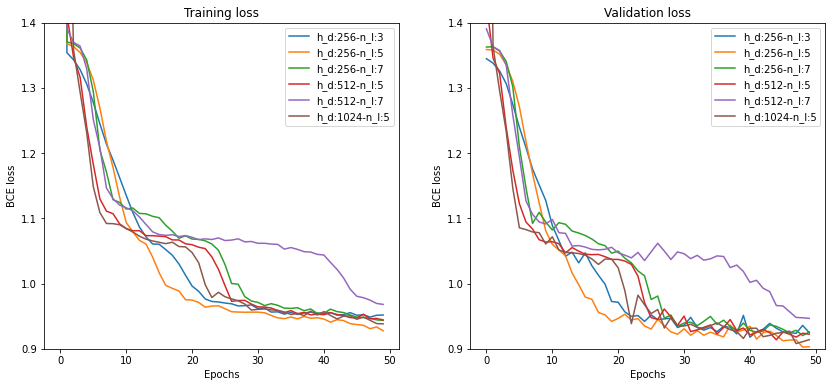

In [ ]:
plot_losses(res_mult_train_gcn, (0.9, 1.4), figsize=(14, 6))

From the curves we can understand that the better combinations of values are the ones that consider a hidden dimension of 256 with 5 stacked layers, or 512 hidden dimensions with 5 stacked layers. Let's check if the numerical values confirm this hypothesis.

In [ ]:
create_results_table(res_mult_train_gcn)

AUROC@20    mAP@20  recall@20
h_dim: 256 - n_lay: 3   0.899281  0.130129   0.264332
h_dim: 256 - n_lay: 5   0.918302  0.161356   0.312126
h_dim: 256 - n_lay: 7   0.910393  0.143701   0.290515
h_dim: 512 - n_lay: 5   0.903448  0.135242   0.274316
h_dim: 512 - n_lay: 7   0.896142  0.124003   0.257971
h_dim: 1024 - n_lay: 5  0.911424  0.150276   0.293543

Our hypothesis is confirmed, the best GCN model, considering all metrics, is the one that considers 256 as hidden dimensions and 5 layers. 

Given that the function also returns the best model and predictor, we can further test them. The obtained results are quite good but obviously we would test more complex models in order to improve them. 

In [ ]:
test_metrics_gcn = test_model(best_gcn, best_pred_gcn, emb, adj_t, val_data, 20,
                              metrics=['auc', 'recall', 'map'], num_comp=10)

print_scores(test_metrics_gcn)

The results for the AUROC@20:
- score: 0.918081  - variance: 1.5e-07

The results for the mAP@20:
- score: 0.1601  - variance: 7.31e-06

The results for the recall@20:
- score: 0.309775  - variance: 4.95e-06



### GraphSAGE Baseline

It is characterized by a two-steps process of neighbor sampling and aggregation (along with a non-linearity) for creating node embeddings. Stacking successive layers allow nodes to increase their receptive field, i.e. to incorporate information from nodes that are distant. 
In GraphSAGE the *lth-layer* embedding for a node **v** is derived from the following equation:

$$h_v^l = \sigma(W^l \cdot CONCAT(h_v^{l-1}, AGG(\{h_u^{l-1},\forall u \in N(v)\})))$$

In the first stage, the messages from all the neighbors of v are aggregated (i.e. the embeddings from the (*l-1*)th layer are aggregated), moreover GraphSAGE has an additional step, aggregating the results from the neighbors with the v's embedding from the (*l-1*)th layer.

Then the $\sigma$ fuction can be any non-linearity (e.g. RELU) and AGG can be either a simple average or sum over all the messages, or it may incorporate a LSTM to act upon neighbors' embeddings.

Additionally, L2-normalization can be applied to the embeddings at each layer and also neighbors sampling in case of large graph where full-batch training is not feasible.

Once we have generated node embeddings using the GNN, we can use the embeddings for any pair of nodes to predict whether they should be linked. As predictor, we use the same one declared in a previous cell, that simply computes the dot product of the two node embeddings, followed by a sigmoid.

In [ ]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout, aggr="add"):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels, normalize=True, aggr=aggr))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels, normalize=True, aggr=aggr))
        self.convs.append(SAGEConv(hidden_channels, out_channels, normalize=True, aggr=aggr))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
        for conv in self.convs[:-1]:
            x = conv(x, adj_t)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x

Also with this new model, we will test different parameters to check what are the best ones in order to get the best scores.

In [ ]:
# Parameters to test
h_dim = [256, 256, 256, 512, 512, 1024]
n_layers = [3, 5, 7, 3, 5, 5]
lr = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
dropout = 0.3

# Perform the training for multiple models
res_mult_train_sage, best_sage, best_pred_sage = find_hyperparameters(SAGE, DotProductLinkPredictor,
                                                                      h_dim, n_layers, lr, emb, adj_t,
                                                                      train_data, val_data, dropout, epochs=50)

Training multiple models: 100%|██████████| 6/6 [02:24<00:00, 24.05s/it]


We print the losses as before and we see immediately that the losses are a bit higher than before, and the training has a lot of obscillations but we need to check the scores before doing further considerations.

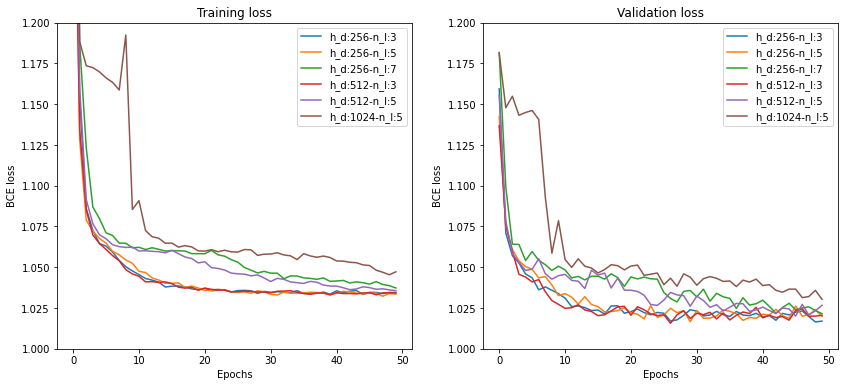

In [ ]:
plot_losses(res_mult_train_sage, (1.0, 1.2), figsize=(14, 6))

In [ ]:
create_results_table(res_mult_train_sage)

AUROC@20    mAP@20  recall@20
h_dim: 256 - n_lay: 3   0.942444  0.306304   0.485266
h_dim: 256 - n_lay: 5   0.940210  0.269765   0.446715
h_dim: 256 - n_lay: 7   0.936355  0.248035   0.425894
h_dim: 512 - n_lay: 3   0.942639  0.305250   0.484911
h_dim: 512 - n_lay: 5   0.937785  0.252800   0.430354
h_dim: 1024 - n_lay: 5  0.925743  0.205546   0.380081

The scores suggest us that this model works better, as expected, and the best set of parameters are: 256 for the hidden dimensions and 3 or 5 layers or the model with 512 hidden dimensions and 3 layers. As you can see, up to now, the models that work better are the ones with a limited number of layers, this is due to the over-smoothing problem. 

Let's repeat the test with the best one (256 hidden dimensions, 3 layers):

In [ ]:
test_metrics_sage = test_model(best_sage, best_pred_sage, emb, adj_t, val_data, 20,
                              metrics=['auc', 'recall', 'map'], num_comp=10)

print_scores(test_metrics_sage)

The results for the AUROC@20:
- score: 0.942797  - variance: 2e-07

The results for the mAP@20:
- score: 0.306239  - variance: 4.71e-06

The results for the recall@20:
- score: 0.485225  - variance: 4.29e-06



The results are much better than the ones obtained in the analysis with R, where we compared the embeddings of the songs in the latent space. 
However we have to explore other different solutions to find which is the best strategy. 

### GraphSAGE with post processing

Adding more layers onto a GNN can get detrimental because it may ends up with embeddings that are very similar each other (over-smoothing). We can try to include post-processing layers in the GNN, which don't pass messages, but simply apply a neural network to the embeddings. This can be convenient when the embeddings need to be used in a downstream task, such as the link prediction we wish to perform.

In [ ]:
class PostProcessSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_dimension, out_channels, num_conv_layers,
                 num_linear_layers, dropout):
        super(PostProcessSAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.lins = torch.nn.ModuleList()
        
        self.convs.append(SAGEConv(in_channels, hidden_dimension, normalize=True, aggr="add"))
        for _ in range(num_conv_layers - 1):
            self.convs.append(SAGEConv(hidden_dimension, hidden_dimension, normalize=True, aggr="add"))
        
        for _ in range(num_linear_layers - 1):
            self.lins.append(torch.nn.Linear(hidden_dimension, hidden_dimension))
        self.lins.append(torch.nn.Linear(hidden_dimension, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
        for conv in self.convs[:-1]:
            x = conv(x, adj_t)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)

        # Post-process
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
        x = self.lins[-1](x)
        return x

In this case we created the model considering the best choices of the previous runs for the hidden dimensions and the number of GCN layers. The more interesting parameter for this model is the number of post-processing layers.

In [ ]:
# Parameters to test
h_dim = [256, 256, 256, 512, 512, 1024]
n_layers = [3, 3, 5, 3, 5, 3]
post_layers = [3, 5, 3, 3, 3, 3]
lr = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
dropout = 0.3

# Perform the training for multiple models
res_mult_train_postsage, best_postsage, best_pred_postsage = find_hyperparameters(PostProcessSAGE, DotProductLinkPredictor,
                                                                    h_dim, n_layers, lr, emb, adj_t,
                                                                    train_data, val_data, dropout, epochs=50,
                                                                    pred_layers=post_layers, post_proc=True)

Training multiple models: 100%|██████████| 6/6 [02:39<00:00, 26.63s/it]


The loss for some models is very irregular (see h_d:512-n_l:5), but generally they have similar losses, apart from the one with 256 hidden dimensions, 3 GCN layers and 3 post-processing layers, that outperforms the others.

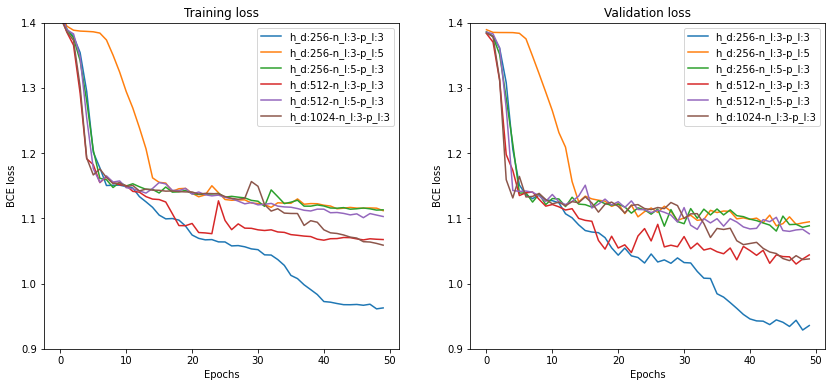

In [ ]:
plot_losses(res_mult_train_postsage, (0.9, 1.4), figsize=(14, 6), pred_layers=True)

We have the confirmation from the table of scores, the best models are the two with 256 as hidden dimensions, 3/5 GCN layers and 3 post-processing layers.

In [ ]:
create_results_table(res_mult_train_postsage, pred_layers=True)

AUROC@20    mAP@20  recall@20
h_dim: 256 - n_lay: 3- pr_lay: 3   0.907359  0.148651   0.294106
h_dim: 256 - n_lay: 3- pr_lay: 5   0.779879  0.062422   0.151111
h_dim: 256 - n_lay: 5- pr_lay: 3   0.782865  0.062362   0.152593
h_dim: 512 - n_lay: 3- pr_lay: 3   0.839320  0.087089   0.192464
h_dim: 512 - n_lay: 5- pr_lay: 3   0.784424  0.060822   0.156989
h_dim: 1024 - n_lay: 3- pr_lay: 3  0.836013  0.081768   0.190950

Let's compute again the metrics with the best model:

In [ ]:
test_metrics_postsage = test_model(best_postsage, best_pred_postsage, emb, adj_t, val_data, 20,
                              metrics=['auc', 'recall', 'map'], num_comp=10)

print_scores(test_metrics_postsage)

The results for the AUROC@20:
- score: 0.907212  - variance: 1.4e-07

The results for the mAP@20:
- score: 0.149236  - variance: 3.11e-06

The results for the recall@20:
- score: 0.294283  - variance: 2.63e-06



Even the best model performs worse than the GraphSAGE baseline and the simple GCN model, probably because we introduced other layers in the postprocessing step that don't help in recognizing the edges that should exist, therefore they add useless computation to the process.

### GraphSAGE with neural link predictor

Changing the GNN model we were not able to improve the results, therefore we can implement a more clever link predictor, making use of a simple neural network. In this case we are trying to improve the quality of the predictions and not the quality of the created embeddings.

Although this seems similar to the post-processing we did previously, the limitation of the prior method was that the model had to generate individual node embeddings that could directly be used for making link predictions for all possible pairs of nodes. By instead having a LinkPredictor, as an independent neural network that can operate directly on pairs of nodes and take into account their unique interactions, this task becomes easier and the model becomes much more expressive (Inspired by [this code](https://github.com/snap-stanford/ogb/blob/master/examples/linkproppred/ddi/gnn.py)).

In [ ]:
class NeuralLinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(NeuralLinkPredictor, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x).squeeze()

We test this new predictor with the base SAGE model for two reasons, the first one is that it obtained better scores than the PostProcessSAGE, as second reason is that we use a different approach for the link prediction, therefore the two models would not work well together.

In this case we train the models for 50 epochs to have a fair comparison with the other models and then for 100 epochs to see if the results will improve more.

In [ ]:
# Parameters to test for 50 epochs
h_dim = [256, 256, 256, 512, 512, 512]
n_layers = [3, 5, 3, 3, 5, 5]
pred_layers = [3, 3, 5, 3, 3, 5]
lr = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
dropout = 0.3

# Perform the training for multiple models
res_mult_train_sage_np, best_sage_np, best_pred_sage_np = find_hyperparameters(SAGE, NeuralLinkPredictor,
                                                                    h_dim, n_layers, lr, emb, adj_t,
                                                                    train_data, val_data, dropout, epochs=50,
                                                                    pred_layers=pred_layers)

Training multiple models: 100%|██████████| 6/6 [03:14<00:00, 32.47s/it]


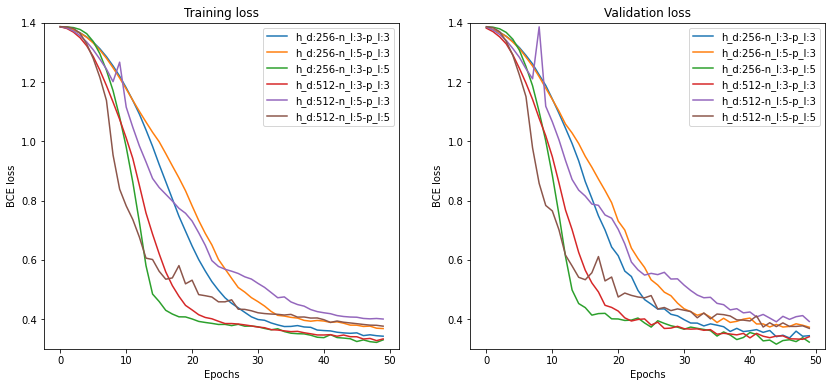

In [ ]:
plot_losses(res_mult_train_sage_np, (0.3, 1.4), figsize=(14, 6), pred_layers=True)

Even after 50 epochs the models obtained very good scores and the best one is better than the SAGE model + the DotProductLinkPredictor.

In [ ]:
create_results_table(res_mult_train_sage_np, pred_layers=True)

AUROC@20    mAP@20  recall@20
h_dim: 256 - n_lay: 3- pr_lay: 3  0.964675  0.305956   0.483253
h_dim: 256 - n_lay: 5- pr_lay: 3  0.960904  0.283606   0.460837
h_dim: 256 - n_lay: 3- pr_lay: 5  0.964879  0.310261   0.487826
h_dim: 512 - n_lay: 3- pr_lay: 3  0.964840  0.304283   0.480209
h_dim: 512 - n_lay: 5- pr_lay: 3  0.956008  0.263268   0.435781
h_dim: 512 - n_lay: 5- pr_lay: 5  0.958529  0.264708   0.442480

As said before, let's now train the models for 100 epochs to see what happens, notice that the parameters are the same as the training with 50 epochs.

In [ ]:
# Parameters to test for 100 epochs
h_dim = [256, 256, 256, 512, 512, 512]
n_layers = [3, 5, 3, 3, 5, 5]
pred_layers = [3, 3, 5, 3, 3, 5]
lr = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
dropout = 0.3

# Perform the training for multiple models
res_mult_train_sage_np, best_sage_np, best_pred_sage_np = find_hyperparameters(SAGE, NeuralLinkPredictor,
                                                                    h_dim, n_layers, lr, emb, adj_t,
                                                                    train_data, val_data, dropout, epochs=100,
                                                                    pred_layers=pred_layers)

Training multiple models: 100%|██████████| 6/6 [05:31<00:00, 55.32s/it]


The errors after the 50th epoch still decrease, this means that the models learnt something more than before and the scores may be better. 

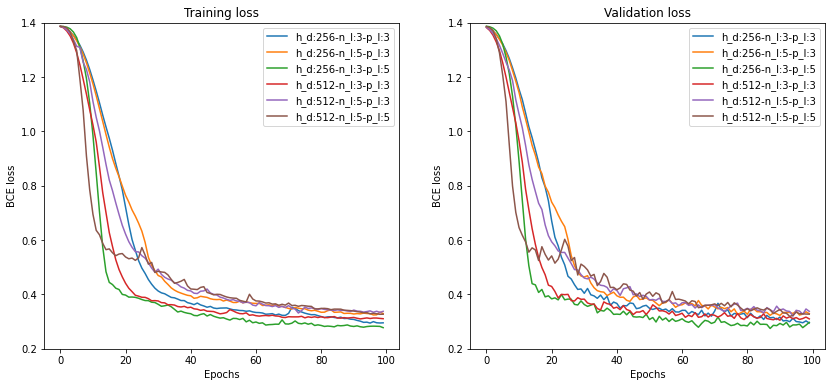

In [ ]:
plot_losses(res_mult_train_sage_np, (0.2, 1.4), figsize=(14, 6), pred_layers=True)

The scores are actually better and now, three models are better than the best one with SAGE + DotProductLinkPredictor. 

In [ ]:
create_results_table(res_mult_train_sage_np, pred_layers=True)

AUROC@20    mAP@20  recall@20
h_dim: 256 - n_lay: 3- pr_lay: 3  0.967495  0.320978   0.497826
h_dim: 256 - n_lay: 5- pr_lay: 3  0.962624  0.290028   0.463913
h_dim: 256 - n_lay: 3- pr_lay: 5  0.970006  0.336942   0.515813
h_dim: 512 - n_lay: 3- pr_lay: 3  0.966138  0.314774   0.491240
h_dim: 512 - n_lay: 5- pr_lay: 3  0.961746  0.281686   0.456731
h_dim: 512 - n_lay: 5- pr_lay: 5  0.963002  0.288760   0.466457

The best model is the one with 256 as hidden dimensions, 3 SAGEConv layers and 5 layers for the neural predictor, but all the models obtained very high scores. 

In [ ]:
test_metrics_postsage = test_model(best_sage_np, best_pred_sage_np, emb, adj_t, val_data, 20,
                              metrics=['auc', 'recall', 'map'], num_comp=10)

print_scores(test_metrics_postsage)

The results for the AUROC@20:
- score: 0.970196  - variance: 6e-08

The results for the mAP@20:
- score: 0.338508  - variance: 1.159e-05

The results for the recall@20:
- score: 0.517383  - variance: 6.06e-06



In [ ]:
torch.save(best_sage_np.state_dict(), "best_sage_weights.pt")
torch.save(best_pred_sage_np.state_dict(), "best_np_weights.pt")

With this predictor, we obtained better scores than with the post-processing model and the SAGE one, clearly a more expressive LinkPredictor can take the embeddings generated by our basic GNN and start making reasonably good predictions.

The AUC is better than the one computed with the SAGE + the DotProduct predictor, this means that the model is able to predict better if an edge is a positive or a negative sample and it is also able to suggest more similar songs because both the mAP and the recall increased. 

### GraphSAGE with edge features

The last thing that we may want to try is to use some edge features, to check if this can lead to better suggestions.

Prior work by [Lu et al.](https://github.com/lustoo/OGB_link_prediction/blob/main/Link%20prediction%20with%20structural%20information.pdf) found that distance encoding methods may work well for some datasets, as nodes that are estimated to be close together have a higher chance of being connected by an edge, therefore I will use those distances as edge features between nodes.

Trying to calculate the shortest-path distances between all nodes can get computationally intractable. Instead, I can approximate distances by leveraging an anchor set of K randomly sampled nodes. I first calculate the distance from each of these K nodes to all other nodes in the graph. Then I use these distances to get a reasonable approximation of the distance between any two nodes in the graph.

$$d_{u,v} \approx \frac{1}{K} \sum \limits_{k \in anchor} d_{k,u} + d_{k,v}$$

We can create the matrix of anchor set distances using networkx library, but first we need to convert the PyTorch sparse tensors to a scipy matrix.

In [ ]:
import networkx as nx
import random

In [ ]:
scipy_mat = graph_dataset[0].adj_t.to_scipy(layout='coo')
graph_anch = nx.Graph(scipy_mat)

Naturally with larger values of K you get a better approximation of the distances between nodes, in our case a value of 400 can be a reasonable number for a set of ~6000 nodes. Furthermore, empirically the improvements of the results were negligible using a K of 800.

In [ ]:
def compute_spd_k(graph_anch, num_nodes, K=400):
    '''
        It computes the shortest path distances using an anchor set of K nodes.
    '''
    sampled_nodes = sorted(random.sample(graph_anch.nodes, K))
    spd = torch.ones(num_nodes, K, dtype=torch.float64)

    for k in tqdm(range(K)):
        from_k_to_all = nx.shortest_path_length(graph_anch, source=sampled_nodes[k])
        for node in from_k_to_all:
            # For each node I have the distance from the k anchor nodes
            spd[node][k] = from_k_to_all[node]

    spd = spd.float()

    return spd

In [ ]:
spd = compute_spd_k(graph_anch, num_nodes, K=400).to(device)

100%|██████████| 400/400 [00:19<00:00, 20.26it/s]


In order to include the edge features we have to change the SAGEConv layer to implement the message passing that considers them, a similar implementation can be found at [this link](https://github.com/lustoo/OGB_link_prediction/blob/main/DDI/link_pred_ddi_graphsage_edge.py).

The message sent by a node $v$, neighbor of a node $u$ becomes:

$$m_v^l = h_v^{l-1} + W_e \cdot d_{u,v}$$


In [ ]:
class SAGEConvWithEdges(MessagePassing):
    def __init__(self, in_channels,
                 out_channels, normalize = False,
                 root_weight = True,
                 bias = True, **kwargs):  
        kwargs.setdefault('aggr', 'add')
        super(SAGEConvWithEdges, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.root_weight = root_weight

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_l = torch.nn.Linear(in_channels[0], out_channels, bias=bias)
        self.lin_e = torch.nn.Linear(1, in_channels[0], bias=bias)
        if self.root_weight:
            self.lin_r = torch.nn.Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_e.reset_parameters()
        if self.root_weight:
            self.lin_r.reset_parameters()


    def forward(self, x, edge_index, spd, size = None):
        if isinstance(x, torch.Tensor):
            x = (x, x)
        # propagate() takes in the edge indices and all additional data which is
        # needed to construct messages and to update node embeddings
        out = self.propagate(edge_index, x=x, spd=spd)
        out = self.lin_l(out)
        
        x_r = x[1]
        if self.root_weight and x_r is not None:
            out += self.lin_r(x_r)
            
        if self.normalize:
          out = F.normalize(out, p=2., dim=-1)
        return out


    def message(self, x_j, spd_i, spd_j):
        dist_mean = torch.mean(spd_i + spd_j, 1, True)
        return F.relu(x_j + self.lin_e(dist_mean))


    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)

In [ ]:
class EdgeSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout, aggr="mean"):
        super(EdgeSAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConvWithEdges(in_channels, hidden_channels, normalize=True, aggr=aggr))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConvWithEdges(hidden_channels, hidden_channels, normalize=True, aggr=aggr))
        self.convs.append(SAGEConvWithEdges(hidden_channels, out_channels, normalize=True, aggr=aggr))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, edge_index, spd):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index, spd)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index, spd)
        return x

In this case is computationally expensive to try a lot of different combinations, therefore we focus on some key values (the best ones from the previous runs).

In [ ]:
# Parameters to test for 100 epochs
h_dim = [256, 256, 256, 256, 512, 512]
n_layers = [3, 3, 5, 5, 3, 5]
pred_layers = [3, 5, 3, 5, 3, 5]
lr = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
dropout = 0.3

# Perform the training for multiple models
res_mult_train_edge_sage, best_edge_sage, best_pred_edge_sage = find_hyperparameters(EdgeSAGE, NeuralLinkPredictor,
                                                                    h_dim, n_layers, lr, emb, adj_t,
                                                                    train_data, val_data, dropout, epochs=100,
                                                                    pred_layers=pred_layers, edge_model=True,
                                                                    spd=spd)

Training multiple models: 100%|██████████| 6/6 [11:34<00:00, 115.80s/it]


Using 0.001 as starting value for the learning rate is not good, the losses curve show a lot of obscillations, but the models seem to learn anyway. 

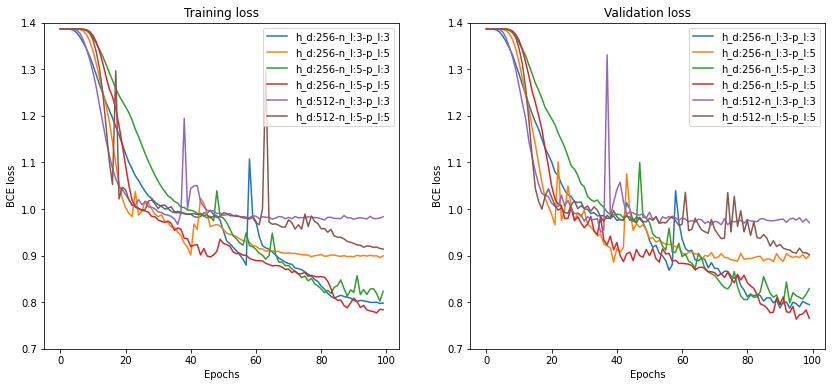

In [ ]:
plot_losses(res_mult_train_edge_sage, (0.7, 1.4), figsize=(14, 6), pred_layers=True)

As you can see from the following table, the scores are lower than the ones obtained with the previous models, and the training lasted 100 epochs, more than before.

In [ ]:
create_results_table(res_mult_train_edge_sage, pred_layers=True)

AUROC@20    mAP@20  recall@20
h_dim: 256 - n_lay: 3- pr_lay: 3  0.871143  0.088449   0.207601
h_dim: 256 - n_lay: 3- pr_lay: 5  0.829698  0.084492   0.189807
h_dim: 256 - n_lay: 5- pr_lay: 3  0.872943  0.102668   0.221562
h_dim: 256 - n_lay: 5- pr_lay: 5  0.878486  0.108626   0.232367
h_dim: 512 - n_lay: 3- pr_lay: 3  0.829427  0.076936   0.195201
h_dim: 512 - n_lay: 5- pr_lay: 5  0.835749  0.103988   0.221417

Given that the training was not satisfactory, we could try to use a lower learning rate and to improve the dropout to see if the training will get better. For the models with a low hidden dimension number we should use a higher learning, while for the ones with a hidden dimension of 512 we can use a starting value that is half of the one used in the previous training.

In [ ]:
# Parameters to test for 100 epochs
h_dim = [256, 256, 256, 512, 512]
n_layers = [3, 3, 5, 3, 5]
pred_layers = [3, 5, 3, 3, 5]
lr = [0.001, 0.0008, 0.001, 0.0005, 0.0005]
dropout = 0.4

# Perform the training for multiple models
res_mult_train_edge_sage, best_edge_sage, best_pred_edge_sage = find_hyperparameters(EdgeSAGE, NeuralLinkPredictor,
                                                                    h_dim, n_layers, lr, emb, adj_t,
                                                                    train_data, val_data, dropout, epochs=100,
                                                                    pred_layers=pred_layers, edge_model=True,
                                                                    spd=spd)

Training multiple models: 100%|██████████| 5/5 [09:45<00:00, 117.18s/it]


As you can see from the graph, the training is better than before, curves are smoother, apart from few obscillations, in particular for the model of 512 hidden dimensions, 5 SAGE layers and 5 neural predictor layers (the most complex).

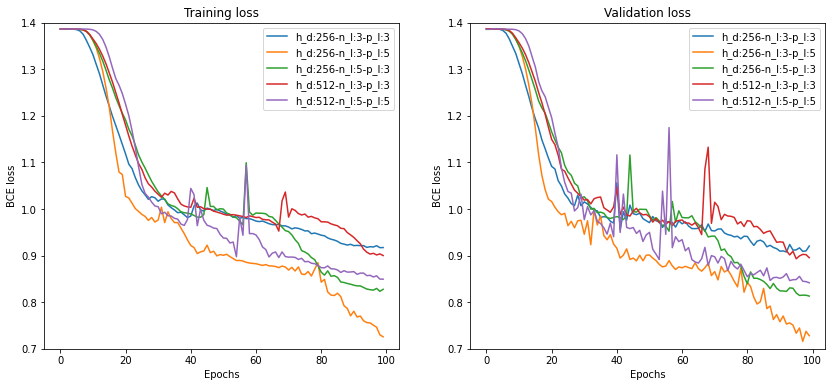

In [ ]:
plot_losses(res_mult_train_edge_sage, (0.7, 1.4), figsize=(14, 6), pred_layers=True)

The scores don't change a lot, but the new best model with the new settings is the one with 256 hidden dimensions, 3 SAGE layers and 5 predictor layers.

It is likely that we can get better results if we train the models for more epochs and if we tune the hyperparameters, but this is not the goal of the project.

In [ ]:
create_results_table(res_mult_train_edge_sage, pred_layers=True)

AUROC@20    mAP@20  recall@20
h_dim: 256 - n_lay: 3- pr_lay: 3  0.818681  0.054288   0.134992
h_dim: 256 - n_lay: 3- pr_lay: 5  0.895147  0.113749   0.247311
h_dim: 256 - n_lay: 5- pr_lay: 3  0.862914  0.082748   0.197424
h_dim: 512 - n_lay: 3- pr_lay: 3  0.825115  0.056747   0.141675
h_dim: 512 - n_lay: 5- pr_lay: 5  0.860429  0.079101   0.192576

In [ ]:
test_metrics_edgesage = test_model(best_edge_sage, best_pred_edge_sage, emb, adj_t, val_data, 20,
                          metrics=['auc', 'recall', 'map'], num_comp=10,
                          edge_model=True, spd=spd)

print_scores(test_metrics_edgesage)

The results for the AUROC@20:
- score: 0.894896  - variance: 7e-08

The results for the mAP@20:
- score: 0.111247  - variance: 2.57e-06

The results for the recall@20:
- score: 0.246095  - variance: 4.82e-06



There could be different reasons for the scores to deteriorate, the main one is that we introduced further complexity but we already struggled a bit with simpler model, due to the low number of nodes.

Moreover, using the shortest path distances as edge features, may be a good idea but it requires some further analysis, for example how many anchor nodes to use. there is no guarantee that these features work well with our dataset, as said at the beginning, they worked well for the ogbl-ddi dataset. However it was worth to try.

## Qualitative evaluation

Our best model is GraphSAGE, used in combination with the NeuralLinkPredictor, at this point we want to test how it works in practice.

Up to now, we only checked the scores obtained in the different metrics, now we also want to see if the suggested songs are actually similar to a given one. Therefore I wrote a simple function that predict the k most similar songs and return them. 

In [ ]:
#@title #### Function to retrieve k most similar songs information
from IPython.display import display

@torch.no_grad()
def test_suggestions(model, predictor, embeddings, adj_t, test_data, k, reduced_df,
                     mapping_to_df, song=None, core_mapping=None):
    '''
        It tests the model returning the most similar songs to a given one.

        Parameters:
            - model:
                The GNN model that creates the embeddins for the nodes.
            - predictor:
                The predictor that returns the probability of a link for each pair
                of nodes.
            - embeddings: torch.Tensor
                The embeddings of the nodes.
            - adj_t: torch.Tensor
                The sparse matrix that contains the edges.
            - test_data: torch_geometric.data.data.Data
                The data to use for the test.
            - k: int
                It is the number of similar songs that the model has to return.
            - reduced_df: pd.DataFrame
                The dataframe from which the function will retrieve the information
                about the suggested songs.
            - mapping_to_df: dict
                The mapping to retrieve the item id from the core id.
            - song: int
                The item id of the song to test. If None, a random song is sampled.
            - core_mapping: dict
                If a song is passed, it's requested also to pass the dictionary with
                the mapping from item id to core id.
        Returns:
            - pd.DataFrame
                It returns the row of the dataframe with the song selected to be
                tested and a second dataframe with the similar songs.
    '''
    model.eval()
    predictor.eval()

    h = model(embeddings, adj_t)

    # Create the dictionary that keep songs with at least k similar ones and the indices of the similars
    similar_songs = get_similar_dict(test_data.pos_edge_label_index, k, verbose=False)
    pos_eval_edge = test_data.pos_edge_label_index
    num_test_nodes = k*20

    # Take one random song from the test set
    if song is None:
        available_songs = list(similar_songs.keys())
        test_song = available_songs[random.randint(0, len(available_songs))]
    else:
        # Check if the mapping has been passed and the song is part of the core graph
        try:
            if core_mapping == None:
                print("ERROR: you need to pass the mapping with the selected song.")
                return None, None
            test_song = core_mapping[str(song)]
        except:
            print("ERROR: the passed song is not part of the core graph.")
            return None, None

    # Take the songs similars to test_song and create a tensor
    similars_test = similar_songs[test_song]
    sim_dest_nodes = torch.tensor(similars_test[:k]).to(device)

    # I have to choose wrong, random nodes, therefore I remove the similars from the choice
    rand_nodes = pos_eval_edge[0, torch.isin(pos_eval_edge[0,:], sim_dest_nodes, invert=True)]
    rand_num = num_test_nodes - len(sim_dest_nodes)
    # Sample only unique nodes, selecting them among a set of the values
    rand_nodes = torch.tensor(random.sample(set(rand_nodes.cpu().tolist()), rand_num)).to(device)

    dest = torch.cat([sim_dest_nodes, rand_nodes])
    src = torch.full((len(dest), ), test_song).to(device)

    pred_songs = predictor(h[src], h[dest]).squeeze().cpu()

    # Retrieve the k most probable predicted links (edges)
    top_k_idx = torch.topk(pred_songs, k)[1]
    predicted_k = dest[top_k_idx].tolist()
    res_ids = [mapping_to_df[str(pred)] for pred in predicted_k]
    tested_song = mapping_to_df[str(test_song)]

    return pd.DataFrame(reduced_df.iloc[tested_song]).transpose(), reduced_df.iloc[res_ids]

If you don't pass any particular song to the function, it will automatically sample one random song from the k-core graph and it will return the most similar.

We show an example in which the selected song comes from 'death metal' genre, to check if the suggested ones are related to it. But first, if you didn't run the notebook, you can load the weights of the best SAGE model and the NeuralLinkPredictor from Drive.

In [ ]:
# Download the files from Drive
url_sage_weights = "1cTsyWTf9UNVKVLtDlhFcW5cVniqmZiG8"
url_np_weights  = "14QPNN4epM4vDU1Pamvd5YQhzB0J0NbIO"

sage_w_path = "sage_best_weights.pt"
np_w_path = "np_best_weights.pt"

gdown.download(id=url_sage_weights, output=sage_w_path, quiet=False)
gdown.download(id=url_np_weights, output=np_w_path, quiet=False)

# Load the model with the best parameters found and load the weights
model = SAGE(emb.size(1), 256, 256, 3, 0.3).to(device)
predictor = NeuralLinkPredictor(256, 256, 1, 5, 0.3).to(device)

model.load_state_dict(torch.load(sage_w_path, map_location=device))
predictor.load_state_dict(torch.load(np_w_path, map_location=device))

Downloading...
From: https://drive.google.com/uc?id=1cTsyWTf9UNVKVLtDlhFcW5cVniqmZiG8
To: /content/sage_best_weights.pt
100%|██████████| 1.46M/1.46M [00:00<00:00, 34.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=14QPNN4epM4vDU1Pamvd5YQhzB0J0NbIO
To: /content/np_best_weights.pt
100%|██████████| 1.06M/1.06M [00:00<00:00, 26.7MB/s]


<All keys matched successfully>

In [ ]:
test_song, sim_songs = test_suggestions(model, predictor, emb, adj_t, test_data,
                                        20, reduced_df, core_to_old_id, song=48460,
                                        core_mapping=old_to_core_id)

In [ ]:
print("The selected song is:")
display(test_song.loc[:,['title', 'artist_name', 'lyrics', 'tag']])
print("\nand have the following lyrics:\n")
display(test_song.lyrics.item())
print("\nThe similar songs are:")
display(sim_songs.loc[:,['title', 'artist_name', 'lyrics', 'tag']])

The selected song is:


title artist_name  \
48460  Lying With Demons  Immolation   

                                                  lyrics          tag  
48460  come one one one never feel heart us fall arou...  death metal


and have the following lyrics:



'come one one one never feel heart us fall around hand hear cri soul thought break watch wrong fire breath mani death knew angel rise saw lay wast lead shadow shall devil desir weak forc tongu rage demon demon poison guid prove seek releas victim divin wick fever mass whose iron deceiv chosen righteous wrath tempt grasp scorn devast'


The similar songs are:


title          artist_name  \
72809  The Conductors Departure                Anata   
53461              Wicked World             Skinless   
4525                      Manic          Monstrosity   
34537                   Deviant            Benighted   
32144       The Carcass Derrick  Cattle Decapitation   
14336            Crown The Liar           Immolation   
2003          Ripsaw Resentment     Blood Red Throne   
52926          Anechoic Chamber     Cephalic Carnage   
303     Fragments of Resolution          Monstrosity   
44989   Mutilation Of The Flesh       Severe Torture   
17469         Slaughtering Void              Krisiun   
45639               Iron Stakes              Krisiun   
28478                 Nocturnal        God Dethroned   
69809              Fractionized             Neuraxis   
8392               Facelphiliac       Severed Savior   
19247               Retaliation             Vomitory   
11543              Rotting Hill             Vomitory   
27820     When Silence Conquers             Vomitory   
233           Throught Adjuster             Neuraxis   
7090            Sense Of Demise             SINISTER   

                                                  lyrics  \
72809  like like time come one one make say would wou...   
53461  know go go got got say day day life world die ...   
4525   like like time make make make life life life l...   
34537  one life eye thing tell tell mind mind still h...   
32144  love time come never let ca life could die liv...   
14336  know come one see want way take day could worl...   
2003   life world made kill high blood sound work bod...   
52926  want world noth old dead kill breath air water...   
303    life eye eye dream mind find must breath truth...   
44989  like one live live mind lie end word word soul...   
17469  call soul burn pain pain dead black son wind e...   
45639  like like one one heart heart fall fall god go...   
28478  come go never never never night night night ni...   
69809  know see world good alway believ believ god th...   
8392   one thing die man give give find find find fin...   
19247  make way life life life eye eye die leav leav ...   
11543  way die die die die die die die die head left ...   
27820  away life rain blood blood death bodi war war ...   
233    know time time come never day world man mind m...   
7090   time one let make night night night world live...   

                         tag  
72809            death metal  
53461            death metal  
4525             death metal  
34537                 french  
32144            death metal  
14336            death metal  
2003             death metal  
52926            death metal  
303              death metal  
44989            death metal  
17469            death metal  
45639            death metal  
28478            death metal  
69809            death metal  
8392                   metal  
19247            death metal  
11543            death metal  
27820            death metal  
233    Technical Death Metal  
7090             death metal

As you can see, all the suggested songs are very related to the selected one, therefore our best model is able to predict, with a good ratio, which songs may be the most similar with respect to a given one. 

In the following cells we print another example where the function took a random song from the available ones.

In [ ]:
test_song, sim_songs = test_suggestions(model, predictor, emb, adj_t, val_data,
                                        20, reduced_df, core_to_old_id)

In [ ]:
print("The selected song is:")
display(test_song.loc[:,['title', 'artist_name', 'lyrics', 'tag']])
print("\nand have the following lyrics:\n")
display(test_song.lyrics.item())
print("\nThe similar songs are:")
display(sim_songs.loc[:,['title', 'artist_name', 'lyrics', 'tag']])

The selected song is:


title artist_name  \
26340  SON GET WREC  Black Moon   

                                                  lyrics      tag  
26340  know know know know know like time time de one...  Hip-Hop


and have the following lyrics:



'know know know know know like time time de one get get get get see got let say take take would day life life life back could could could look caus gonna tell tell man live wanna around around littl littl littl call call everi wait ya word word word word word word god god god last play play thought show peopl da put bring fuck fuck fuck fuck sweet yes real real real real real two year year fli black black big ride street street came ask wind ai hell knew knew em em em em em em wall fill fill white moon shit shit shit shit shit shit hit hit hit hit rest lover peac mother speak becom nigga nigga nigga nigga nigga nigga nigga nigga repeat repeat repeat hot lyric within push three lip bout goin sight mad mad mad evil kick kick kick bitch nice weak weak weak weak known shot shot everyday lock vers vers vers vers vers four ass ass ass lookin state state welcom corner school five mr style cmon gettin fake quick talkin fuckin fuckin least short rhyme dice runnin runnin park g bag stuff niggaz 


The similar songs are:


title           artist_name  \
44035                      BUCK EM DOWN            Black Moon   
57152      Indian Girl (An Adult Story)            Slick Rick   
63243                            Stress   Organized Konfusion   
54411                               MVP                 Big L   
65923                        8 Iz Enuff                 Big L   
8953                          My Adidas               Run DMC   
62949                      Money Folder            Madvillain   
38789                             4_5_6            Kool G-Rap   
48505                          Truth Is           Brother Ali   
11798           Life In Marvelous Times               Mos Def   
58506                             What?  A Tribe Called Quest   
59800                  The Ruler's Back            Slick Rick   
27757  75 Bars (Black's Reconstruction)             The Roots   
60429                            A To G         Blackalicious   
27808                   Without A Doubt             The Roots   
58718                           Rebirth          Public Enemy   
45567                         Clockwork       Dilated Peoples   
50223              Wu-Tang: 7th Chamber          Wu-Tang Clan   
29650                         The Beast                Fugees   
26453                          Creepin'                Redman   

                                                  lyrics      tag  
44035  know know know know know like time time de one...  Hip-Hop  
57152  love love like like like time time come come g...  Hip-Hop  
63243  know know know like time come go one get never...  Hip-Hop  
54411  love love like like like like like like come c...      rap  
65923  know know know know like like like like like l...  Hip-Hop  
8953   know know like like like like time go one one ...  Hip-Hop  
62949  know like like like like like time come go one...  Hip-Hop  
38789  like like like like like like like like like l...  Hip-Hop  
48505  love like like go go go one one get get get ge...  Hip-Hop  
11798  love love know like like time time time time t...  Hip-Hop  
58506  know know like like go go go go go go go go se...  Hip-Hop  
59800  like like time go go go one one one get get ge...  Hip-Hop  
27757  love know know know like like like like like l...  Hip-Hop  
60429  like come go got got got back man man man fall...  Hip-Hop  
27808  know like like like like like like time come o...  Hip-Hop  
58718  know know like like like go get get see got ne...      rap  
45567  like like like like like like like like come c...  Hip-Hop  
50223  know like like like like like like like like l...  Hip-Hop  
29650  like like like like like like like like like l...  Hip-Hop  
26453  like like like like come go one one get get se...  Hip-Hop

## Conclusions

We can conclude that, the best models, considering our dataset, are the simplest ones, with a small number of layers and hidden dimensions. The entire analysis is probably affected by the dimensions of the dataset, we need to restric it in order to run all the models in a reasonable amount of time, it's likely that the same models would not perform very well on bigger datasets.

Therefore, our analysis can be useful to understand the different GNN models that can be applied in the field of recommendation systems, particularly focusing on link prediction task, but the final results are only related to our particular case.

However, we can say that GNNs can be used effectively to create recommendation song systems, indeed all the models work better than the method explored in the R notebook, where we use the cosine similarity among the vectors in the latent space to recommend a song from its lyrics.

I created a final table with the best results obtained for each architecture:

In [ ]:
#@title ####Print the final table
df_fin_results = pd.DataFrame(columns=['AUROC@20', 'mAP@20', 'recall@20'])
aucs_mod = [0.918302, 0.942444, 0.907359, 0.970006, 0.895147]		
map_mod = [0.161356, 0.306304, 0.148651, 0.336942, 0.113749]
recall_mod = [0.312126, 0.485266, 0.294106, 0.515813, 0.247311]
index = ["GCN - DOT_Pred", "SAGE - DOT_Pred", "Post_SAGE - DOT_Pred", "SAGE - NEU_Pred", "EdgeSAGE - NEU_Pred"]
		
df_fin_results['AUROC@20'] = aucs_mod
df_fin_results['mAP@20'] = map_mod
df_fin_results['recall@20'] = recall_mod
df_fin_results.index = index
df_fin_results.sort_values('AUROC@20', ascending=False)

AUROC@20    mAP@20  recall@20
SAGE - NEU_Pred       0.970006  0.336942   0.515813
SAGE - DOT_Pred       0.942444  0.306304   0.485266
GCN - DOT_Pred        0.918302  0.161356   0.312126
Post_SAGE - DOT_Pred  0.907359  0.148651   0.294106
EdgeSAGE - NEU_Pred   0.895147  0.113749   0.247311

# KGE
In this last part of the notebook, we can explore the link prediction task using KGE. We will test multiple models on one dataset, [WN18RR](https://paperswithcode.com/dataset/wn18rr), afterwards we will compare an implementation of a KGE model that leverages LMs, with the SOTA models focused on the structure. 

KGs have become a very spread tool to represent entities and the relations that connect them. They provide a concise and intuitive abstraction for a variety of domains, where edges capture semantic relations between the entities in biology, social data, bibliographical citations, etc.   

More specifically, a KG is a set of resource description framework triples (head, relation, tail), a lot of open KGs are available online but despite their huge size, they are incomplete. Some techniques exist to refine the KG, LP is one of the most common refinement solutions, it exploits the existing facts to infer missing ones. Although effective in representing structured data, the symbolic nature of the triples makes KGs difficult to manipulate, for this reason most of LP models, use KG elements to learn low-dimensional representations and then employ them to create new facts.

KG embedding aims to map entities and their relations to a continuous vector space. Traditional KG embedding methods represent each entity or each relation with a fixed vector. For any triplet $(h,r,t)$, they use a scoring function $f(h, r, t)$ to model its likelihood.

In order to better understand how to start the comparison, a recommended paper is [Comprehensive Analysis of Knowledge Graph Embedding Techniques Benchmarked on Link Prediction](https://www.mdpi.com/2079-9292/11/23/3866), in which the authors compared different representative encoders and considered 6 widespread datasets.

In [ ]:
!pip install -q pykeen #--use-deprecated=backtrack-on-build-failures
#!pip install -q transformers
#!pip install -q datasets
!pip install --upgrade --no-cache-dir -q gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 23.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 7.5 MB/s eta 0:00:00


In [ ]:
import pykeen
from pykeen import datasets, pipeline

import torch
from torch import nn
import numpy as np
import pandas as pd
#from transformers import AutoModelForMaskedLM
#from datasets import load_dataset, Dataset

import gc
import gdown
import json
import random, os

from sklearn.cluster import *
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.preprocessing import *
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from matplotlib.text import Annotation

#import seaborn as sns

INFO:pykeen.utils:Using opt_einsum


## Dataset exploration

WN18RR is a link prediction dataset created from WN18, a subset of WordNet. WN18 consists of 18 relations and 40,943 entities. However, many text triples are obtained by inverting triples from the training set. Thus the WN18RR dataset is created to ensure that the evaluation dataset does not have inverse relation test leakage. In summary, WN18RR dataset contains 93,003 triples with 40,943 entities and 11 relation types. Furthermore, this dataset follows a strictly hierarchical structure.

In [ ]:
wn_18_rr = datasets.get_dataset(dataset="WN18RR")
train_triples = wn_18_rr.training.triples

# Get the entities and relations lists
entities = set()
relations = set()
# Rebuild the mapping from labels to ids for the subset
entity_to_id = {}
relation_to_id = {}

for trip in train_triples:
    entities.add(trip[0].item())
    if not trip[0].item() in entity_to_id:
        entity_to_id[trip[0].item()] = len(entity_to_id)

    relations.add(trip[1].item())
    if not trip[1].item() in relation_to_id:
        relation_to_id[trip[1].item()] = len(relation_to_id)

    entities.add(trip[2].item())
    if not trip[2].item() in entity_to_id:
        entity_to_id[trip[2].item()] = len(entity_to_id)

mapped_triples = np.zeros_like(train_triples, dtype=int)
for i in range(mapped_triples.shape[0]):
    mapped_triples[i, 0] = entity_to_id[train_triples[i,0]]
    mapped_triples[i, 1] = relation_to_id[train_triples[i,1]]
    mapped_triples[i, 2] = entity_to_id[train_triples[i,2]]

wn_18_id = pykeen.triples.TriplesFactory(mapped_triples, entity_to_id, relation_to_id)
wn_18_train, wn_18_val, wn_18_test = wn_18_id.split([0.8,0.1,0.1])

INFO:pykeen.datasets.utils:Caching preprocessed dataset to file:///root/.data/pykeen/datasets/wn18rr/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.datasets.base:Requesting dataset from https://github.com/TimDettmers/ConvE/raw/master/WN18RR.tar.gz
INFO:pykeen.datasets.base:Extracted to /root/.data/pykeen/datasets/wn18rr.
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=40559, num_relations=11, create_inverse_triples=False, num_triples=86835, path="/root/.data/pykeen/datasets/wn18rr/train.txt") to file:///root/.data/pykeen/datasets/wn18rr/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.datasets.base:Stored training factory to file:///root/.data/pykeen/datasets/wn18rr/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=40559, num_relations=11, create_inverse_triples=False, num_triples=2924, path="/root/.data/pykeen/datasets/wn18rr/test.txt") to file:///root/.data/pykeen/datasets/wn18r

In [ ]:
id_label_entmap = wn_18_id.entity_id_to_label
label_id_entmap = pykeen.utils.invert_mapping(id_label_entmap)

We can take the definitions of the entities from the [original dataset](https://everest.hds.utc.fr/doku.php?id=en:transe#data), such that we can observe the readable names of the entities instead of labels and ids. In the following cell you will find the code for downloading and creating the mapping from ids to strings.

Let's analyze the triplets, for example which heads, tails and relations are most prevalent.

In [ ]:
# Download entity definitions from Drive
url_def_wn = "1AwBNWUK2emfb9UwypwgVEqaGfzlkV4Gu"
gdown.download(id=url_def_wn, output="wn_ent_def.txt", quiet=True)

# Import the data about the entities
with open("wn_ent_def.txt") as fin:
    ent_name = {}
    for line in fin.readlines():
        cols = line.split()
        ent_name[int(cols[0])] = cols[1]

In [ ]:
print(f"Number of Entities: {wn_18_train.num_entities}")
print(f"Number of Relations: {wn_18_train.num_relations}")

print(f"Number of Triples:\n Train: {wn_18_train.num_triples}\n Validation:{wn_18_val.num_triples} \n Test:{wn_18_test.num_triples}")

n_top = 10
print("\nMost common relations in training:")
for i, rel in enumerate(wn_18_train.get_most_frequent_relations(n_top)):
    print(f"{i+1}. {wn_18_rr.training.relation_id_to_label[rel]}")

print("\nMost common entities in training:")
entity_count = {i:0 for i in range(wn_18_train.num_entities)}
for triple in wn_18_train.mapped_triples:
    entity_count[triple[0].item()] += 1 
    entity_count[triple[2].item()] += 1

top_entities = sorted(list(entity_count.items()), key = lambda x: x[1], reverse=True)[:n_top]
for i, ent in enumerate(top_entities):
    lab = wn_18_train.entity_id_to_label[ent[0]]
    print(f"{i+1}. {ent_name[int(lab)]}")

INFO:pykeen.triples.triples_factory:applying cutoff of 10 to TriplesFactory(num_entities=40559, num_relations=11, create_inverse_triples=False, num_triples=69468)


Number of Entities: 40559
Number of Relations: 11
Number of Triples:
 Train: 69468
 Validation:8683 
 Test:8684

Most common relations in training:
1. _also_see
2. _derivationally_related_form
3. _has_part
4. _hypernym
5. _member_meronym
6. _member_of_domain_region
7. _member_of_domain_usage
8. _similar_to
9. _synset_domain_topic_of
10. _verb_group

Most common entities in training:
1. __urban_center_NN_1
2. __united_kingdom_of_great_britain_and_northern_ireland_NN_1
3. __soul_NN_2
4. __asterid_dicot_genus_NN_1
5. __bird_genus_NN_1
6. __mammal_genus_NN_1
7. __rosid_dicot_genus_NN_1
8. __herbaceous_plant_NN_1
9. __war_machine_NN_1
10. __magnoliopsid_genus_NN_1


## Models for link prediction

Typically, when working with KGE, there are three main steps:
- define the representation space;
- define a scoring function;
- learn representations.

In the first step you need to specify the form in which entities and relations are modeled; in the second step you need to choose a function to measure the plausibility of each fact and distinguish correct triples from incorrect ones; in the last one the model updates the embeddings by maximizing the total plausibility of the facts.

We will test some famous models such as [TransE](https://proceedings.neurips.cc/paper/2013/file/1cecc7a77928ca8133fa24680a88d2f9-Paper.pdf) and [ConvE](https://arxiv.org/abs/1707.01476) using the pykeen *pipeline* class and the others cloning the directories with the code of the authors of the papers. 

A model that it is worth to test is [HAKE](https://arxiv.org/pdf/1911.09419.pdf), because it is the best on link prediction task considering the WN18RR dataset (according to the authors of ***'Comprehensive Analysis of Knowledge Graph Embedding Techniques Benchmarked on Link Prediction'***) and it can leverage the hierarchical structure of a dataset. Moreover it seems the best trade-off between effectiveness and efficiency, the last point is quite important given our limited available resources.

The other model that we want to test is LASS, a joint language semantic and structure embedding for knowledge graph completion, which incorporates both semantics and structures in a KG triplet.

### TransE and ConvE

**TransE** is a simple neural embedding model for knowledge representation in which entities and relationships are embedded in a continuous vector space. It models relationships by interpreting them as translations operating on the low-dimensional embeddings of the entities. The underlying assumption of TransE is that if a relationship holds between two entities, the vector representation of the relationship should be close to the vector representations of the entities.
TransE uses distance metrics, such as the L1 or L2 distance, to measure the closeness between vectors, indeed it's part of the translational models. 

During training, the model is presented with a set of triplets of the form $(h, r, t)$ and learns embeddings that minimize the following constraint equation:

$$\gamma - d(h, r, t) = \gamma - ||h + r - t||_2$$

This model is efficient and scalable but fails to model complex relations, such as one-to-many, many-to-one, many-to-many, and symmetric links.
<br>
<br>

----
<br>

**ConvE** is a model for knowledge embedding that uses convolutional neural networks (CNNs) to embed knowledge from a knowledge graph into a continuous vector space. It is the first model that used CNNs for the LP task.  
CNNs have the ability to extract multi-scale local space features and combine them to build semantically rich representationss for the entities, moreover they can capture complex nonlinear relationships by learning with significantly fewer parameters.

ConvE has a different idea of scoring function with respect to TransE, it is the output of a model that works on the embeddings. To do this operation there are different steps:
- get the entity and relation embeddings and concatenate them to have a 2D representation;
- this matrix goes through a convolutional network to obtain a feature map tensor;
- reshape the tensor into a vector, project it into a lower dimensional space through a linear transformation and compute the correlation with the entity matrix.

### HAKE

***Hierarchy-aware knowledge graph embedding*** (HAKE) is a translational distance model that maps entities into the polar coordinate system, in order to model *semantic hierarchies*. It is inspired by the fact that concentric circles in the polar coordinate system can naturally reflect the hierarchy, specifically, the radial coordinate aims to model entities at different levels of the hierarchy; the angular coordinate aims to distinguish entities at the same level of a hierarchy. The latter are expected to have almost the same radii but different angles, as you can see in the following image taken from the paper:

<img src="https://miralab.ai/publication/aaai-2020-hake/featured.png" alt="Hake paper image" width="50%"/>

The score function is defined by joining the modulus part m (to distinguish the hierarchy levels) and the phase part p (to determine entities at the same level):

$f(h,r,t) = − ||h_m \circ r_m−t_m||_2 − \gamma ||sin(h_p + r_p − t_p) / 2||_1$

where $\circ$ is the Hadamard product and $\sin(\cdot)$ is an operation that applies the sine function to each element of the input.

#### Train the model


To test the model we clone the Github directory of the authors and we run the training with the parameters used by them.

In [ ]:
!git clone https://github.com/MIRALab-USTC/KGE-HAKE.git

Cloning into 'KGE-HAKE'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 60 (delta 2), reused 4 (delta 1), pack-reused 54
Unpacking objects: 100% (60/60), 24.48 MiB | 6.68 MiB/s, done.


The used parameters are:
- ciao
- mamma

During the training we avoid to use the validation set due to some RAM issues with the size of the dataset.

In [ ]:
os.putenv("CUDA_VISIBLE_DEVICES", "0")

!cd KGE-HAKE && python -u codes/runs.py --do_train \
                    --do_test \
                    --data_path data/wn18rr \
                    --model HAKE \
                    -n 1024 -b 512 -d 500 \
                    -g 6 -a 0.5 \
                    -lr 0.00005 --max_steps 30000 \
                    -save models/HAKE_wn18rr_0 --test_batch_size 8 \
                    -mw 0.5 -pw 0.5 \
                    -cpu 2 \
                    --save_checkpoint_steps 5000

2023-02-08 13:15:11,948 INFO     Model: HAKE
2023-02-08 13:15:11,948 INFO     Data Path: data/wn18rr
2023-02-08 13:15:11,948 INFO     Num Entity: 40943
2023-02-08 13:15:11,948 INFO     Num Relation: 11
2023-02-08 13:15:11,948 INFO     Num Train: 86835
2023-02-08 13:15:11,948 INFO     Num Valid: 3034
2023-02-08 13:15:11,949 INFO     Num Test: 3134
2023-02-08 13:15:12,328 INFO     Model Parameter Configuration:
2023-02-08 13:15:12,328 INFO     Parameter gamma: torch.Size([1]), require_grad = False
2023-02-08 13:15:12,328 INFO     Parameter embedding_range: torch.Size([1]), require_grad = False
2023-02-08 13:15:12,328 INFO     Parameter entity_embedding: torch.Size([40943, 1000]), require_grad = True
2023-02-08 13:15:12,328 INFO     Parameter relation_embedding: torch.Size([11, 1500]), require_grad = True
2023-02-08 13:15:12,328 INFO     Parameter phase_weight: torch.Size([1, 1]), require_grad = True
2023-02-08 13:15:12,328 INFO     Parameter modulus_weight: torch.Size([1, 1]), require_gr

#### Load saved data

The training is quite long, therefore I left the link to download the embeddings created during the training and the data to further test the model.

In [ ]:
url_pretrain_hake = "1PFfhWDd-gnVz0XvzVRUBW10S8zXAwQh7"
gdown.download(id=url_pretrain_hake, output="hake_pretrained.zip", quiet=True)

!unzip hake_pretrained.zip
!rm hake_pretrained.zip

Archive:  hake_pretrained.zip
   creating: KGE-HAKE/models/HAKE_wn18rr_0/
  inflating: KGE-HAKE/models/HAKE_wn18rr_0/checkpoint  
  inflating: KGE-HAKE/models/HAKE_wn18rr_0/train.log  
  inflating: KGE-HAKE/models/HAKE_wn18rr_0/relation_embedding.npy  
  inflating: KGE-HAKE/models/HAKE_wn18rr_0/config.json  
  inflating: KGE-HAKE/models/HAKE_wn18rr_0/entity_embedding.npy  


In [ ]:
ent_embedd_hake = np.load("HAKE_wn18rr_0/entity_embedding.npy")

In [ ]:
def plot_interactive_pyk(entity_embedding_array, cluster=False):

    entity_emb_orig = entity_embedding_array#entity_embedding_tensor.cpu().detach().numpy()
    entity_emb_orig_norm = normalize(entity_emb_orig)[:10000,:]

    entity_emb_2d = TSNE(n_components=2, random_state=42).fit_transform(entity_emb_orig_norm)

    x = entity_emb_2d[:,0]
    y = entity_emb_2d[:,1]

    if cluster:
        db = DBSCAN(eps=3, min_samples=10).fit(entity_emb_2d)
        c = db.labels_
        n_clusters = max(c)
    else:
        c = [random.randint(1,10) for i in range(len(x))]
        n_clusters = 10

    norm = plt.Normalize(1,n_clusters)
    cmap = plt.cm.hsv

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, c=c, s=3, cmap=cmap, norm=norm)
    plt.title("Representation of entity embeddings (HAKE)")

    plt.show()


'''for model_name in models:
    print("Model:", model_name)

    print("Forward mean rank evaluation:",  results[model_name].get_metric('head.realistic.mean_rank'))
    print("Backward mean rank evaluation:",  results[model_name].get_metric('tail.realistic.mean_rank'))
    print("Head-Tail mean rank evaluation:",  results[model_name].get_metric('both.realistic.mean_rank'))

    print("Mean-reciprocal rank evaluation:",  results[model_name].get_metric('both.realistic.mrr'))
    print("Hits@1 evaluation:",  results[model_name].get_metric('both.realistic.hits_at_1'))
    print("Hits@10 evaluation:",  results[model_name].get_metric('both.realistic.hits_at_10'))

    model = results[model_name].model

    entity_embeddings = model.entity_representations[0]
    relation_embeddings = model.relation_representations[0]

    entity_embedding_tensor = entity_embeddings()
    relation_embedding_tensor = relation_embeddings()

    plot_interactive_pyk(entity_embedding_tensor, cluster=True)''';

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


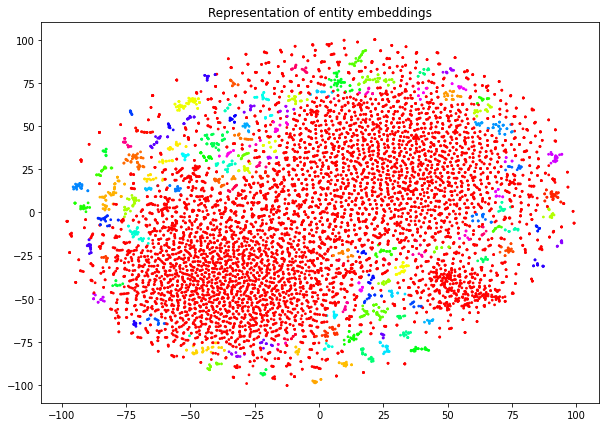

In [ ]:
plot_interactive_pyk(ent_embedd, cluster=True)

## Evaluation

There are different methods for the **evaluation** of KGE models, obviously we will focus on the best metrics for the link prediction task. We followed the metrics considered in the paper about comparison, because they are the most common ones. These metrics are based on the prediction ranks $Q$, checking whether the correct answers can be ranked before synthetic negative.

- ***Mean Rank*** (MR) is the average value of predictions/recommendations among all candidates; therefore, the lower it is, the better the model results are.
    1. $MR = \frac{1}{|Q|} \sum \limits_{q \in Q} q$

- ***Hits@n*** accounts for the proportion of ground-truth triples appearing in the first n top-ranked triples. In the following formula the predicate $𝟙$ yields 1 if $q$ takes values between 1 and $n$, otherwise 0.
    2. $Hits@n = \frac{1}{|Q|} \sum \limits_{q \in Q} 𝟙[q \le n]$

- The ***MRR*** is the average of the reciprocal of the obtained ranks, and it is preferable to MR because of its greater robustness to outliers.
    3. $MRR = \frac{1}{|Q|} \sum \limits_{q \in Q} \frac{1}{q}$

The ***Hits@n*** represents the ability of the model to correctly predict the relationships between triples, the ***MR*** and the ***MRR*** scores reflect the ranking of the correct triples.

In [ ]:
url_pretrain_conve = "1jkWWyTBXRz02wIWsPMxaVvn7rwS5519d"
gdown.download(id=url_pretrain_conve, output="conve_pretrained.zip", quiet=True)

!unzip conve_pretrained.zip
!rm hake_pretrained.zip

In [ ]:
models = ["TransE", "ConvE"]

results = {k:None for k in models}

for model in models:
    result = pipeline.pipeline(
        training=wn_18_train,
        testing=wn_18_test,
        model=model,
        epochs=200
    )

    # Save the results and the trained model
    result.save_to_directory(model)
    results[model] = result
    torch.cuda.empty_cache()
    gc.collect()

INFO:pykeen.pipeline.api:Using device: None


Training epochs on cuda:0:   0%|          | 0/200 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/272 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=1024.


Evaluating on cuda:0:   0%|          | 0.00/8.68k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 3.38s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=40559, num_relations=11, create_inverse_triples=False, num_triples=69468) to file:///content/TransE/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///content/TransE
INFO:pykeen.pipeline.api:Using device: None
The ConvE model should be trained with inverse triples.
This can be done by defining the TriplesFactory class with the _create_inverse_triples_ parameter set to true.
INFO:pykeen.nn.modules:Resolving None * None * None = 200.
INFO:pykeen.nn.modules:Resolved to 1 * 20 * 10 = 200.


Training epochs on cuda:0:   0%|          | 0/200 [00:00<?, ?epoch/s]

INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/271 (0.37%) batches).


Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/271 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=4.


Evaluating on cuda:0:   0%|          | 0.00/8.68k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1198.22s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=40559, num_relations=11, create_inverse_triples=False, num_triples=69468) to file:///content/ConvE/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///content/ConvE


In [ ]:
!zip -r TransE.zip TransE
!zip -r ConvE.zip ConvE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp TransE.zip /content/drive/MyDrive/Text_Mining/GNN/KGE
!cp ConvE.zip /content/drive/MyDrive/Text_Mining/GNN/KGE

In [ ]:
def plot_interactive_pyk(entity_emb_orig, cluster=False):

    entity_emb_orig = entity_embedding_tensor.cpu().detach().numpy()
    entity_emb_orig_norm = normalize(entity_emb_orig)[:10000,:]

    entity_emb_2d = TSNE(n_components=2, random_state=42).fit_transform(entity_emb_orig_norm)

    x = entity_emb_2d[:,0]
    y = entity_emb_2d[:,1]

    if cluster:
        db = DBSCAN(eps=3, min_samples=10).fit(entity_emb_2d)
        c = db.labels_
        n_clusters = max(c)
    else:
        c = [random.randint(1,10) for i in range(len(x))]
        n_clusters = 10

    norm = plt.Normalize(1,n_clusters)
    cmap = plt.cm.hsv

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, c=c, s=3, cmap=cmap, norm=norm)
    plt.title("Representation of entity embeddings (HAKE)")

    plt.show()

Model: TransE
Forward mean rank evaluation: 10357.744140625
Backward mean rank evaluation: 8401.3720703125
Head-Tail mean rank evaluation: 9379.55859375
Mean-reciprocal rank evaluation: 0.09517221613338828
Hits@1 evaluation: 0.0020152003684937815
Hits@10 evaluation: 0.2432634730538922


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


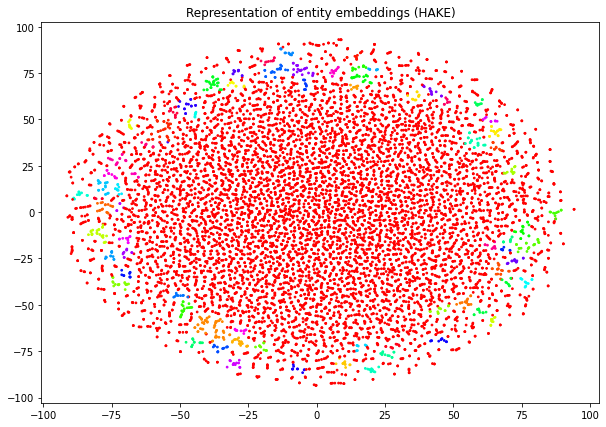

Model: ConvE
Forward mean rank evaluation: 12613.73046875
Backward mean rank evaluation: 11050.291015625
Head-Tail mean rank evaluation: 11832.0107421875
Mean-reciprocal rank evaluation: 0.01739235398737531
Hits@1 evaluation: 0.006678949792722248
Hits@10 evaluation: 0.035985720865960386


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


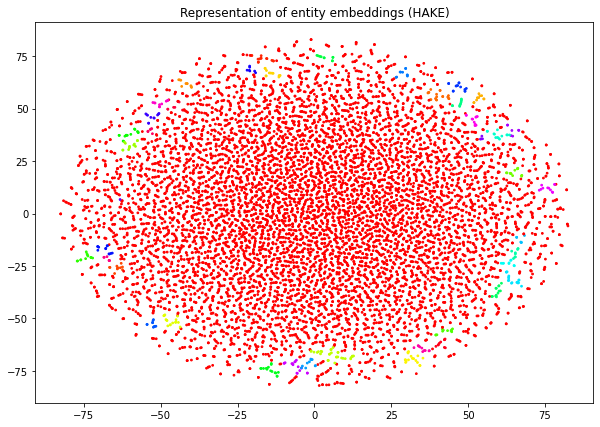

In [ ]:
for model_name in models:
    print("Model:", model_name)

    print("Forward mean rank evaluation:",  results[model_name].get_metric('head.realistic.mean_rank'))
    print("Backward mean rank evaluation:",  results[model_name].get_metric('tail.realistic.mean_rank'))
    print("Head-Tail mean rank evaluation:",  results[model_name].get_metric('both.realistic.mean_rank'))

    print("Mean-reciprocal rank evaluation:",  results[model_name].get_metric('both.realistic.mrr'))
    print("Hits@1 evaluation:",  results[model_name].get_metric('both.realistic.hits_at_1'))
    print("Hits@10 evaluation:",  results[model_name].get_metric('both.realistic.hits_at_10'))

    model = results[model_name].model

    entity_embeddings = model.entity_representations[0]
    relation_embeddings = model.relation_representations[0]

    entity_embedding_tensor = entity_embeddings()
    #relation_embedding_tensor = relation_embeddings()

    plot_interactive_pyk(entity_embedding_tensor, cluster=True)

## Joint Language Semantic and Structure Embedding for Knowledge Graph Completion

In [this paper](https://arxiv.org/pdf/2209.08721.pdf) the authors decided to jointly embed the semantics in the natural language description of the knowledge triplets with their structure information, this led their model to the SOTA for different benchmarks.

Their model, LASS, embeds a triplet into a vector space by fine-tuning pre-trained language models with respect to a structured loss. The semantic embedding captures the semantics of the triplet, which corresponds to the forward pass of a pre-trained LM over the natural language description of the triplet. The structure embedding aims to reconstruct the structures in the semantic embedding, which corresponds to optimizing a probabilistic structured
loss via the backpropagation of the LM. The goal is to reconstruct the structure information in the semantic embedding.

The head, relation and tail are represented as a list of tokens, then the concatenation is passed to the LM and they apply mean pooling over the output representation of each token of the 3 vectors. In particular they also add an initial token [B] and a separation token [S] between the elements, that change w.r.t. the chosen LM. 

The score function of a triplet $(h,r,t)$ is defined as:

$f(h, r, t) = b - \frac{1}{2} ||h + r - t||^2_2$

and motivated by [TransE](https://papers.nips.cc/paper/2013/file/1cecc7a77928ca8133fa24680a88d2f9-Paper.pdf).

The authors defined a probabilistic model based on the score function:

$Pr(h|r,t) = \frac{exp(f(h,r,t))}{\sum_{\hat h \in E} exp(f(\hat h, r,t))}$

where $\hat h$ is the corrupted head sampled from the entity set $E$.     
The probabilistic structured loss is defined as:

$L = - \sum \limits_{(h,r,t) \in G}(log Pr(h|r,t) + log Pr(r|h,t) + log Pr(t|h,r)$

but since it would be computationally inefficient, it requires a forward pass of all possible triplets, they use negative sampling.

For WN18RR, they used definitions of synsets as entity descriptions, the relation descriptions are based on the relation names. For BERT they use a byte-level BPE vocabulary, replacing [B] and [S] with BOS and EOS respectively.

In [ ]:
# Hyperparameters
#batch_size = 128
#lr = 3e-5 #with linear warm-up and 0.01 weight decay
# b = 7 # the margin in the score function, set empirically
# neg_sample = 5 

They consider both MR and Hits@10 to evaluate the results, unfortunately, due to Colab's limited resources, I was only able to run the training with a TinyBERT model, therefore the scores are obviously worse than the ones described in the paper.

TODO: 
- check if albert can run in colab.
- visual representation of LM embedding, https://github.com/jessevig/bertviz.